In [1]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
import gpflow
import numpy as np
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary
%matplotlib inline

def get_channels(client,mobile=None):
    """
    Return list of channel ids
    If mobile = None: All channels
              = True: just mobile
              = False:just static
    """
    
    if mobile is None:
        sql = "SELECT channel_id FROM `airqo-250220.thingspeak.channel` LIMIT 1000"
    else:
        if not mobile: sql = "SELECT channel_id FROM `airqo-250220.thingspeak.channel` WHERE NOT LOWER(name) LIKE '%mobile%' LIMIT 1000"
        else: sql = "SELECT channel_id FROM `airqo-250220.thingspeak.channel` WHERE LOWER(name) LIKE '%mobile%' LIMIT 1000"
    channels = [channel.channel_id for channel in client.query(sql).result()]
    return channels

def get_entries_since(client,channel_id,daysago=7):
    from datetime import datetime,timedelta
    datestring = (datetime.now()-timedelta(daysago)).strftime("%Y-%m-%d %H:%M:%S") # current date and time

    sql = """
    SELECT created_at, latitude, longitude, pm2_5, altitude 
    FROM `airqo-250220.thingspeak.clean_feeds_pms` 
    WHERE channel_id={} 
    AND created_at > '{}'
    """.format(channel_id,datestring)

    df = client.query(sql).to_dataframe() 
    
    return df

/home/mike/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
client = bigquery.Client.from_service_account_json("/home/mike/.gcp_keys/AirQo-519978d8cadc.json")

In [9]:
channelinfo = client.query('SELECT name,description,channel_id FROM `airqo-250220.thingspeak.channel`').to_dataframe()

In [105]:
channels = get_channels(client,mobile=True)
df = None
for channel in channels:
    df = pd.concat([df,get_entries_since(client,channel,daysago=10000)])

In [106]:
#import pickle
#pickle.dump(df,open('mobile_data_cache.p','wb'))
#!ls mobile_data_cache.p -lah

-rw-rw-r-- 1 mike mike 30M Apr 21 13:25 mobile_data_cache.p


In [2]:
df = pickle.load(open('mobile_data_cache.p','rb'))

NameError: name 'pickle' is not defined

In [463]:
#df.sort_values('created_at')

created_at     latitude    longitude  pm2_5  altitude
67246 2018-12-05 11:17:49     0.000000     0.000000  11.97       NaN
68027 2018-12-05 11:18:49  1000.000000  1000.000000   5.67       NaN
68062 2018-12-05 11:19:47  1000.000000  1000.000000   4.83       NaN
68065 2018-12-05 11:20:44  1000.000000  1000.000000   5.11       NaN
67481 2018-12-05 11:21:44  1000.000000  1000.000000   4.91       NaN
...                   ...          ...          ...    ...       ...
41958 2019-12-05 14:53:01     0.357266    32.585808  73.80       NaN
61373 2019-12-05 14:53:35     0.357902    32.586277  74.33       NaN
47176 2019-12-05 14:54:09     0.358767    32.586449  74.53       NaN
73186 2019-12-05 14:54:51     0.359336    32.587101  69.00       NaN
25722 2019-12-05 14:55:27     0.359680    32.588131  66.47       NaN

[649484 rows x 5 columns]

In [108]:
import pyproj
epsg3857 = pyproj.Proj(init='epsg:3857')
wgs84 = pyproj.Proj(init='EPSG:4326')
df['x'],df['y'] = pyproj.transform(wgs84,epsg3857,df['longitude'].tolist(),df['latitude'].tolist())
df['time'] = np.array([t.hour + t.minute/60 + t.second/3600 for t in df['created_at']])

/home/mike/anaconda3/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/mike/anaconda3/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [298]:
mapsize = 0.05
x_range,y_range = pyproj.transform(wgs84,epsg3857, np.array([-mapsize,mapsize])+32.5825,np.array([-mapsize,mapsize])+0.3476)

In [366]:
sres = 250 #spatial resolution
tres = 24  #temporal resolution
toverlap = 3 #how many hours to overlap
sums = np.zeros([sres,sres,tres])
counts = np.zeros([sres,sres,tres])
for i,binstart in enumerate(np.linspace(0,24,tres+1)[:-1]):
    keep = (df['time']>binstart) & (df['time']<binstart+toverlap) | (binstart+toverlap>24) & (df['time']<binstart+toverlap-24)
    idx_x = np.array(sres * (df[keep]['x']-x_range[0])/np.diff(x_range)).astype(np.int)
    idx_y = np.array(sres * (df[keep]['y']-y_range[0])/np.diff(y_range)).astype(np.int)
    keep2 = (idx_x>=0) & (idx_x<sres) & (idx_y>=0) & (idx_y<sres)
    
    for x,y,v in zip(idx_x[keep2],idx_y[keep2],df[keep][keep2]['pm2_5']):
        sums[x,y,i]+=v
        counts[x,y,i]+=1
    #sums[idx_x[keep2],idx_y[keep2],i]+=df[keep][keep2]['pm2_5']
    #counts[idx_x[keep2],idx_y[keep2],i]=counts[idx_x[keep2],idx_y[keep2],i]+1

In [367]:
altsums = np.zeros([sres,sres])
altcounts = np.zeros([sres,sres])
idx_x = np.array(sres * (df['x']-x_range[0])/np.diff(x_range)).astype(np.int)
idx_y = np.array(sres * (df['y']-y_range[0])/np.diff(y_range)).astype(np.int)
keep3 = (idx_x>=0) & (idx_x<sres) & (idx_y>=0) & (idx_y<sres)
keep4 = (df[keep3]['altitude']>0) & (df[keep3]['altitude']<3000)
for x,y,v in zip(idx_x[keep3],idx_y[keep3],df[keep3][keep4]['altitude']):
    altsums[x,y]+=v
    altcounts[x,y]+=1
alts = altsums/altcounts

/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


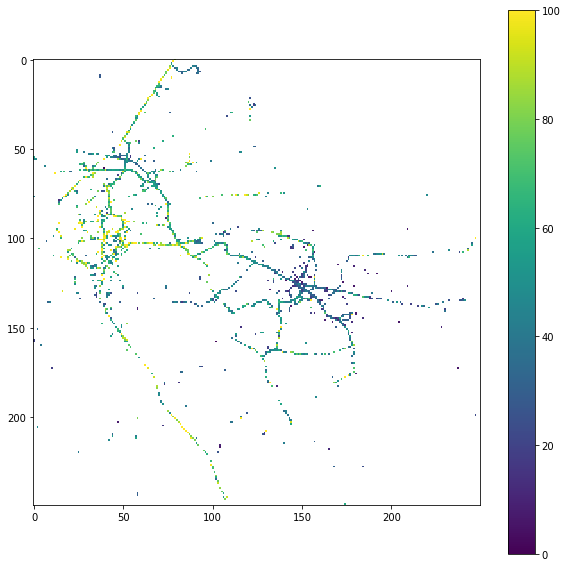

In [372]:
plt.figure(figsize=[10,10])
counts[counts<5]=0 #we'll remove tiles with fewer than a few samples in
vs = (sums/counts)[:,:,7]
cs = counts[:,:,10]
vs[vs>1000]=np.nan

plt.imshow(vs)
plt.clim([0,100])
#plt.imshow(counts[:,:,12])
plt.colorbar()


In [373]:
xgrid = np.linspace(x_range[0],x_range[1],sres)[:,None].repeat(sres,1)
ygrid = np.linspace(y_range[0],y_range[1],sres)[None,:].repeat(sres,0)

In [381]:
vs

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [382]:
import numpy as np
from bokeh.models import Circle, ColumnDataSource,Plot,ColorBar, Ticker
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
from bokeh.palettes import YlOrBr
from bokeh.tile_providers import Vendors, get_provider
from bokeh.io import show, output_notebook, output_file
from bokeh.events import Event, LODEnd
from bokeh.embed import components, file_html
from bokeh.resources import CDN
from bokeh.palettes import Viridis256
tile_provider = get_provider(Vendors.OSM)
vs[vs>300]=300
vs[vs<0]=0
cs[cs<5]=0
cs[cs>=1]=10
cs[np.isnan(vs)]=0
data = {'x':xgrid,'y':ygrid,'vs':vs, 'cs':cs}
source = ColumnDataSource(data)

mapper = linear_cmap(field_name='vs', palette=Viridis256 ,low=10 ,high=100)
#mapper = linear_cmap(field_name='vs', palette=Greys256 ,low=1180 ,high=1230)
glyph = Circle(x="x", y="y", size='cs', line_color=mapper, fill_color=mapper,fill_alpha=1)


# Plot figure and add tiles 


scaled_map = figure(title=None, x_range=x_range, y_range=y_range, x_axis_type="mercator", y_axis_type="mercator")
scaled_map.add_tile(tile_provider)
scaled_map.add_glyph(source, glyph)

output_notebook()
show(scaled_map)

Loading BokehJS ...

/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


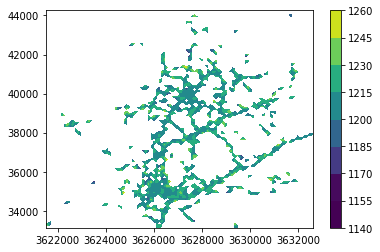

In [349]:
alts = altsums/altcounts
plt.contourf(xgrid,ygrid,altsums/altcounts)
plt.clim([1160,1260])
plt.colorbar()

/home/mike/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mike/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


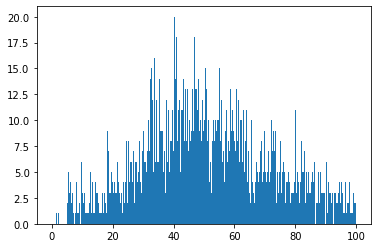

In [378]:
plt.hist(vs.flatten(),300,range=[0,100]);

(1000, 1500)

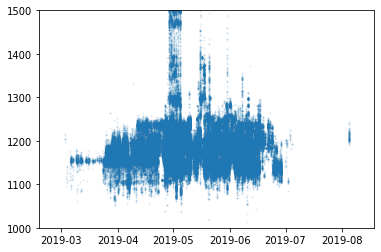

In [357]:
plt.scatter(df['created_at'],df['altitude'],1,alpha=0.1)
plt.ylim([1000,1500])


In [52]:
sql="""SELECT DATETIME_TRUNC(created_at,day) AS Date,
COUNT(*) AS Num
FROM      `airqo-250220.thingspeak.clean_feeds_pms`
GROUP BY Date
ORDER BY Date"""

#GROUP BY  DATEPART(DAY, created_at),
#          DATEPART(MONTH, created_at),
#          DATEPART(YEAR, created_at)
#ORDER BY  'Year',
#          'Month',
#          'Day'"""
records = client.query(sql).to_dataframe()

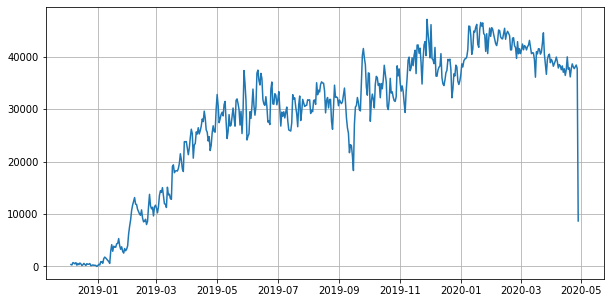

In [56]:
plt.figure(figsize=[10,5])
plt.plot(records.Date,records.Num)
plt.grid()

In [444]:
#(t2.created_at<DATETIME_ADD(t1.created_at, INTERVAL 5 MINUTE)) AND (t1.created_at<DATETIME_ADD(t2.created_at, INTERVAL 5 MINUTE))
#abs(DATETIME_DIFF(t1.created_at,t2.created_at,MINUTE))<5 AND abs(t1.latitude-t2.latitude)<0.0003 

sql = """SELECT t2.channel_id AS channel_id2, t2.created_at AS created_at2, t2.latitude AS latitude2, t2.longitude AS longitude2, t2.pm2_5 AS pm2, t2.altitude AS altitude2, t1.channel_id AS channel1, t1.created_at AS created_at1, t1.latitude AS latitude1, t1.longitude AS longitude1, t1.pm2_5, t1.altitude AS altitude1
FROM `airqo-250220.thingspeak.clean_feeds_pms` AS t1 INNER JOIN `airqo-250220.thingspeak.clean_feeds_pms` AS t2
ON (t1.channel_id<t2.channel_id) 
AND (t1.longitude!=0) AND(t2.longitude!=0) AND (t1.longitude!=1000) AND(t2.longitude!=1000)
AND abs(t1.latitude-t2.latitude)<0.0003
AND abs(t1.longitude-t2.longitude)<0.0003
AND (t2.created_at<DATETIME_ADD(t1.created_at, INTERVAL 5 MINUTE)) 
AND (t1.created_at<DATETIME_ADD(t2.created_at, INTERVAL 5 MINUTE))"""
#sql = "SELECT  DATEDIFF(SECOND,created_at, ) FROM `airqo-250220.thingspeak.clean_feeds_pms` LIMIT 1"
d = client.query(sql).to_dataframe()

KeyboardInterrupt: 

In [3]:
import pickle
import numpy as np
import pandas as pd

In [4]:
#sql = """SELECT * FROM `airqo-250220.thingspeak.clean_feeds_pms`"""
#d = client.query(sql).to_dataframe()
#pickle.dump(d,open('alldata.p','wb'))

In [5]:
df = pickle.load(open('alldata.p','rb'))

In [175]:
prox = 0.0003 #~33m = 0.0003*40075000/360
timeprox = 5 #5 minutes
dfs = []
encounters = None
for cid in df['channel_id'].unique():
    #warning: 0 is for some reason used as a 'non-value' in lat/long entries even though it is a valid point on the Earth.
    df = df[(df['latitude']!=0) & (df['latitude']<=180) & (df['latitude']>=-180) & (df['longitude']!=0) & (df['longitude']<=180) & (df['longitude']>=-180)]
    df['created_at_2']=df['created_at']
    dfs.append(df[df['channel_id']==cid])
for i,d1 in enumerate(dfs):
    for d2 in dfs[i+1:]:
        newdf = pd.merge_asof(d1.sort_values("created_at"),d2.sort_values("created_at"),on='created_at',tolerance=pd.Timedelta(timeprox,'minutes'),direction='nearest'). \
            dropna(subset=["created_at","created_at_2_y",'latitude_x','longitude_x', 'latitude_y', 'longitude_y','pm2_5_x','pm2_5_y'])
        newdf = newdf[(np.abs(newdf['latitude_x']-newdf['latitude_y'])<prox) & (np.abs(newdf['latitude_x']-newdf['latitude_y'])<prox)]
        encounters = pd.concat([encounters,newdf])
    print("%d of %d (%d encounters recorded)" % (i+1,len(dfs),len(encounters)))

1 of 73 (3883 encounters recorded)
2 of 73 (3910 encounters recorded)
3 of 73 (44634 encounters recorded)
4 of 73 (44635 encounters recorded)
5 of 73 (45138 encounters recorded)
6 of 73 (45256 encounters recorded)
7 of 73 (48892 encounters recorded)
8 of 73 (55200 encounters recorded)
9 of 73 (55308 encounters recorded)
10 of 73 (55316 encounters recorded)
11 of 73 (55677 encounters recorded)
12 of 73 (55859 encounters recorded)
13 of 73 (55861 encounters recorded)
14 of 73 (55936 encounters recorded)
15 of 73 (101982 encounters recorded)
16 of 73 (102093 encounters recorded)
17 of 73 (102093 encounters recorded)
18 of 73 (102095 encounters recorded)
19 of 73 (102173 encounters recorded)
20 of 73 (102224 encounters recorded)
21 of 73 (102237 encounters recorded)
22 of 73 (103443 encounters recorded)
23 of 73 (103498 encounters recorded)
24 of 73 (107931 encounters recorded)
25 of 73 (107948 encounters recorded)
26 of 73 (107956 encounters recorded)
27 of 73 (108112 encounters recorded)

In [169]:
pd.merge_asof(d1.sort_values("created_at"),d2.sort_values("created_at"),on='created_at',tolerance=pd.Timedelta(timeprox,'minutes'),direction='nearest').columns

Index(['created_at', 'channel_id_x', 'entry_id_x', 'pm2_5_x', 'pm10_x',
       's2_pm2_5_x', 's2_pm10_x', 'latitude_x', 'longitude_x', 'voltage_x',
       'altitude_x', 'wind_x', 'no_sats_x', 'hdope_x', 'temperature_x',
       'humidity_x', 'channel_id_y', 'entry_id_y', 'pm2_5_y', 'pm10_y',
       's2_pm2_5_y', 's2_pm10_y', 'latitude_y', 'longitude_y', 'voltage_y',
       'altitude_y', 'wind_y', 'no_sats_y', 'hdope_y', 'temperature_y',
       'humidity_y', 'created_at_2'],
      dtype='object')

In [6]:
#pickle.dump(encounters,open('encounters.p','wb'))
import pickle
encounters = pickle.load(open('encounters.p','rb'))
df = pickle.load(open('alldata.p','rb'))
#mobilechannels = channelinfo[channelinfo['name'].str.contains('mobile',case=False)]['channel_id']
#keep = encounters['channel_id_x'].isin(mobilechannels) | encounters['channel_id_y'].isin(mobilechannels)
#encounters = encounters[keep]

In [98]:
mobile = {}
for cid in df.channel_id.unique():
    diffs = df[df.channel_id==cid].latitude.diff()
    mobile[cid] = np.log(np.nanmedian(np.abs(diffs)))>-8

/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


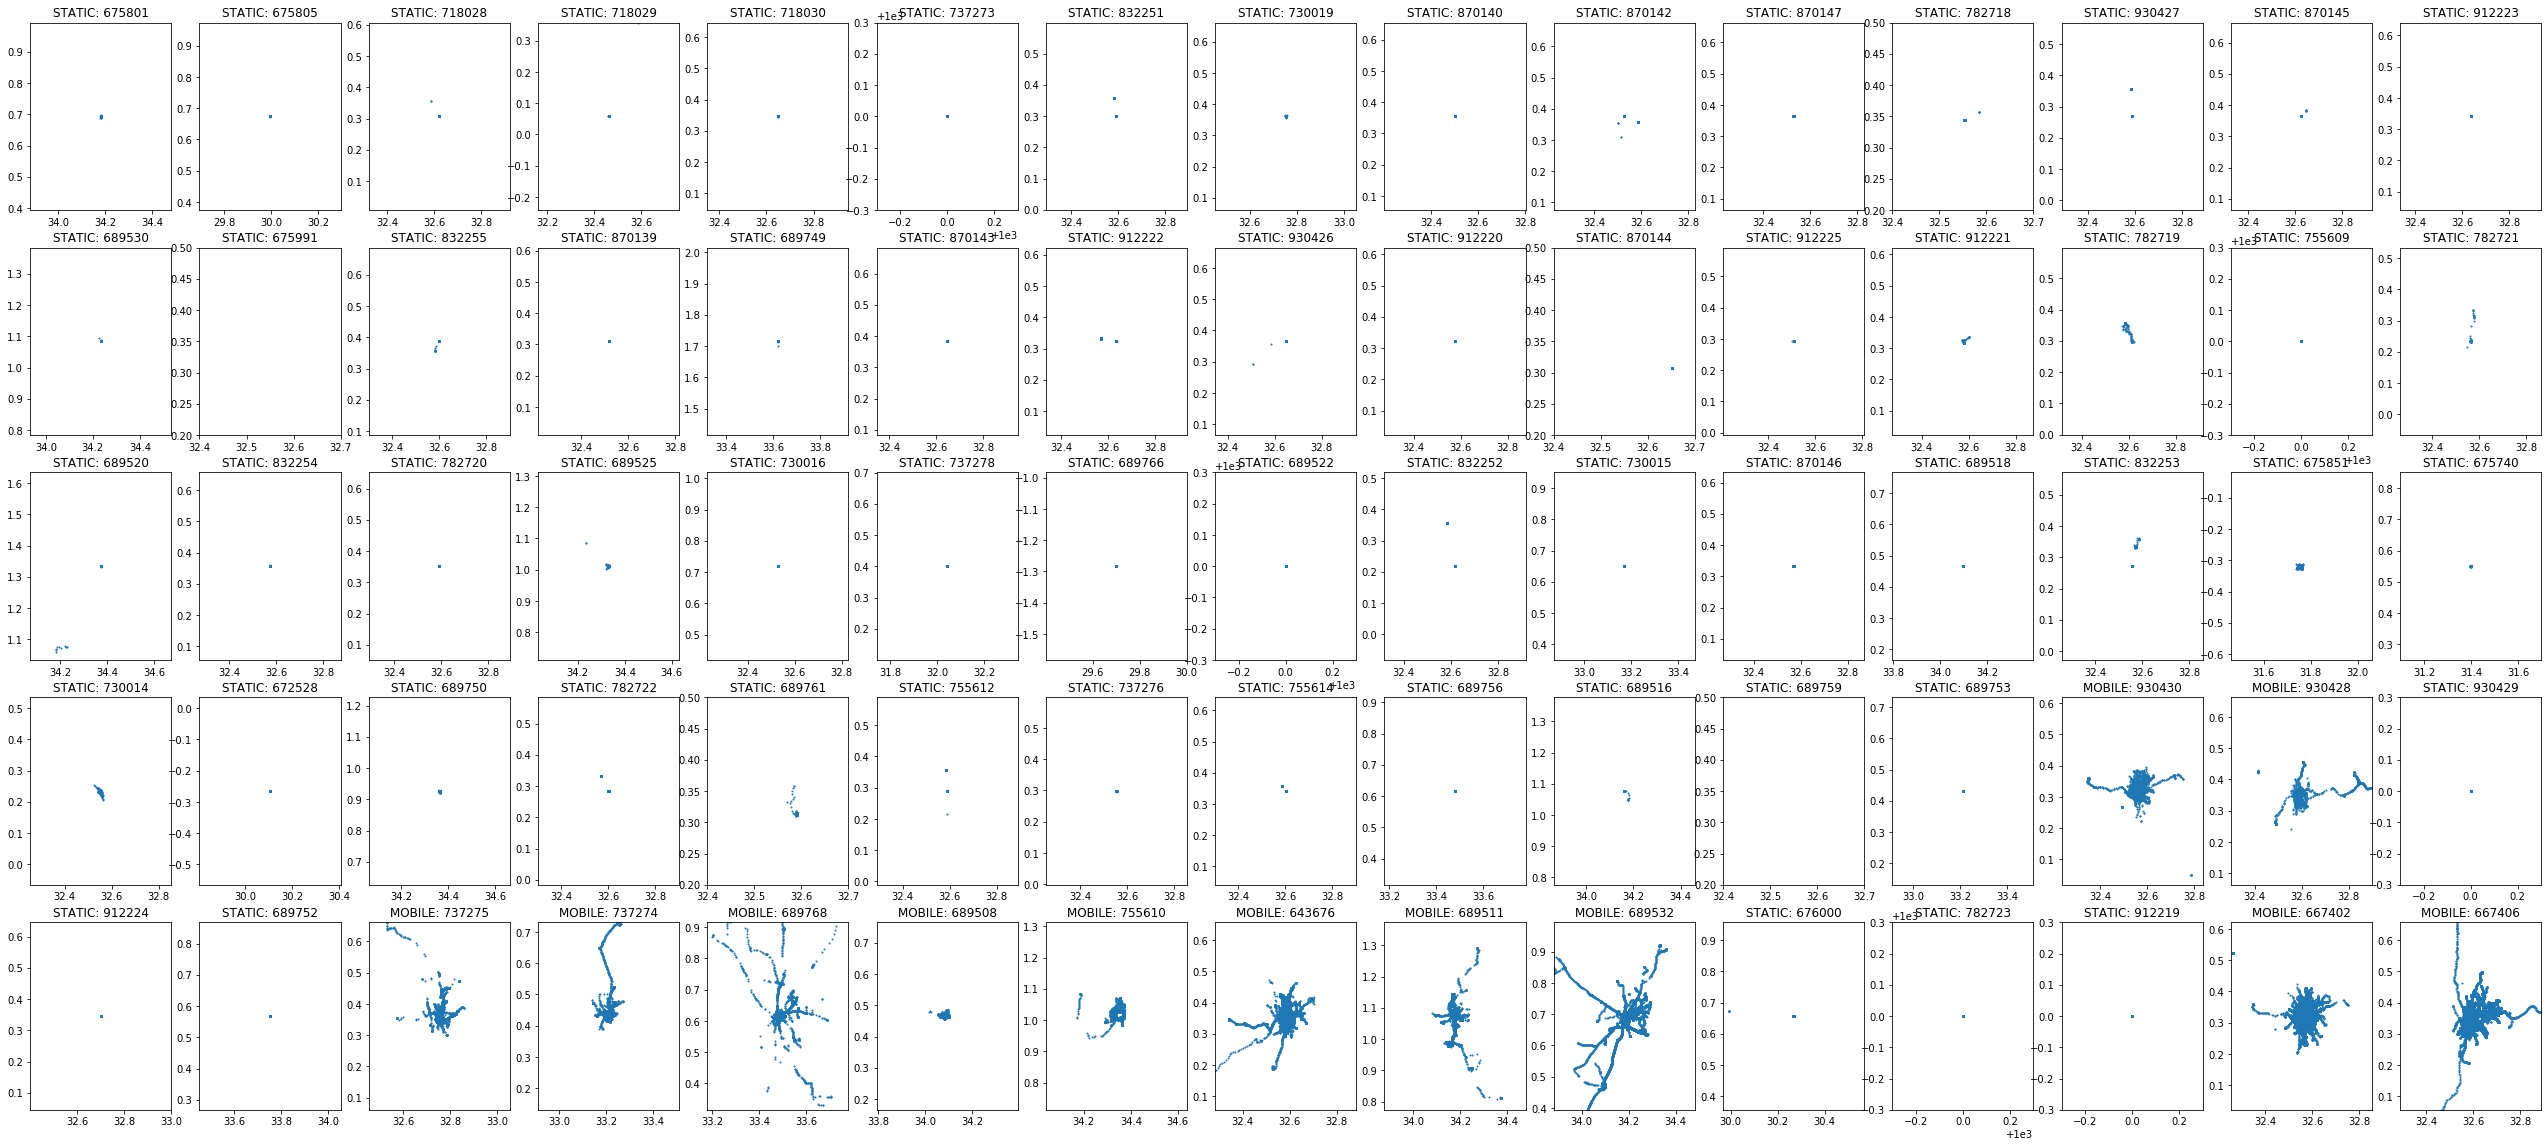

In [21]:
i = 0
plt.figure(figsize=[45,20])
for cid in mobile:
    i+=1
    plt.subplot(5,15,i)
    plt.xlim([32.4,32.7])
    plt.ylim([0.2,0.5])
    
    if mobile[cid]:
        plt.title('MOBILE: %d' % cid)
    else:
        plt.title('STATIC: %d' % cid)
    
    longs = df[df.channel_id==cid].longitude
    lats = df[df.channel_id==cid].latitude
    plt.scatter(longs,lats,1)
    try:
        plt.xlim(np.median(longs)-0.3,np.median(longs)+0.3)
        plt.ylim(np.median(lats)-0.3,np.median(lats)+0.3)
    except ValueError:
        pass

'AIRQO-WB6 UNIT ACTIVE'

In [55]:
from datetime import datetime,timedelta



ImportError: cannot import name 'now'

In [72]:
l = channelinfo[channelinfo['channel_id']==m][['name','description']]
len(l)

1

In [76]:
for m in mobile:
    print("====%d====" % m)
    
    l = channelinfo[channelinfo['channel_id']==m][['name','description']]
    if len(l)>0: 
        print(l.to_numpy()[0][0],"[",l.to_numpy()[0][1],"]")
    else: print("Not in channel data")
    if mobile[m]: print("Identified as Mobile")
    else: print("Identified as Static")
    dates = alldata[alldata['channel_id']==m]['created_at']
    if (max(dates)>datetime.now()-timedelta(7)): maxdate = 'now'
    else: maxdate = str(max(dates))
    print("Data available between %s and %s" % (str(min(dates)),maxdate))
str(a)

====675801====
AIRQO-WB6 UNIT ACTIVE [ AIRQO UNIT with PMS5003 Tororo ]
Identified as Static
Data available between 2019-01-12 15:38:47 and now
====675805====
AIRQO-WB7  UNIT ACTIVE [ AIRQO UNIT with PMS5003 Bundibujo ]
Identified as Static
Data available between 2019-01-12 15:37:47 and 2020-02-03 22:07:17
====718028====
AIRQO-WB29 UNIT ACTIVE [ AIRQO UNIT with PMS5003 Ambrosoli Bugolobi Kampala ]
Identified as Static
Data available between 2019-03-12 09:57:00 and now
====718029====
AIRQO-WB30 UNIT ACTIVE [ AIRQO UNIT with PMS5003 Kiwafu Kitoro Entebbe ]
Identified as Static
Data available between 2019-03-14 19:25:13 and now
====718030====
AIRQO-WB31 UNIT ACTIVE [ AIRQO UNIT with PMS5003 Kireka ]
Identified as Static
Data available between 2019-03-14 19:28:42 and 2020-03-30 06:42:00
====737273====
AIRQO-WB36 UNIT ACTIVE [ AIRQO UNIT with PMS5003 Bweyogerere ]
Identified as Static
Data available between 2019-03-28 07:18:50 and now
====832251====
AirQo-51 Unit Active  [ AirQo Unit with D

Data available between 2019-03-02 18:07:38 and now
====689516====
AIRQO-WB13 UNIT ACTIVE [ AIRQO UNIT with PMS5003 Industrial Division Mbale ]
Identified as Static
Data available between 2019-01-29 11:47:01 and now
====689759====
AIRQO-WB25 UNIT ACTIVE [ AIRQO UNIT with PMS5003 Busembatya Iganga ]
Identified as Static
Data available between 2019-02-15 09:46:42 and now
====689753====
AIRQO-WB23 UNIT ACTIVE [ AIRQO UNIT with PMS5003 Jinja Main Street ]
Identified as Static
Data available between 2019-01-29 19:38:29 and now
====930430====
Not in channel data
Identified as Mobile
Data available between 2020-01-15 10:16:10 and 2020-03-30 17:15:26
====930428====
Not in channel data
Identified as Mobile
Data available between 2020-01-15 09:24:03 and 2020-04-14 05:01:10
====930429====
Not in channel data
Identified as Static
Data available between 2020-01-15 09:58:33 and now
====912224====
AIRQO-69 UNIT ACTIVE [ None ]
Identified as Static
Data available between 2019-12-09 10:02:48 and now
===

'2019-01-06 04:59:21'

[930430,
 930428,
 737275,
 737274,
 689768,
 689508,
 755610,
 643676,
 689511,
 689532,
 667402,
 667406]

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


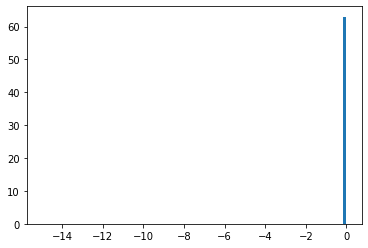

In [509]:
#plt.hist([mobility[i] for i in mobility],bins=np.linspace(-15,0,100));

In [460]:
mobilechannels

26    689511
32    737275
35    737274
36    667406
47    689532
58    643676
61    689768
66    689508
69    667402
73    755610
Name: channel_id, dtype: int64

In [459]:
encounters[keep].sort_values('created_at')

created_at  channel_id_x  entry_id_x  pm2_5_x  pm10_x  \
13654  2019-01-09 09:59:23        643676       14027     7.41   11.34   
13655  2019-01-09 10:00:31        643676       14028     7.15   10.48   
13657  2019-01-09 10:02:47        643676       14030     4.96    7.11   
17314  2019-01-17 09:38:29        643676       17718    12.06   19.65   
17611  2019-01-17 15:21:24        643676       18015     9.19   12.90   
...                    ...           ...         ...      ...     ...   
62032  2019-12-05 11:08:17        870146       62135    48.68   60.12   
62033  2019-12-05 11:09:40        870146       62136    46.43   58.08   
62632  2019-12-05 12:36:58        832254       65200    27.28   32.20   
62712  2019-12-05 14:28:22        832254       65280    51.40   65.02   
194667 2019-12-05 14:41:15        755614      194669    53.80   65.98   

        s2_pm2_5_x  s2_pm10_x  latitude_x  longitude_x  voltage_x  ...  \
13654        48.49       1.39    0.359963    32.585888       3.93  ...   
13655        28.66       1.39    0.359944    32.585869       3.93  ...   
13657        13.62       1.39    0.359951    32.585869       3.93  ...   
17314        41.03       1.39    0.319378    32.508427       3.83  ...   
17611        28.00       1.39    0.360950    32.583717       3.86  ...   
...            ...        ...         ...          ...        ...  ...   
62032        50.03      61.87    0.332278    32.569935       4.15  ...   
62033        50.35      62.63    0.332262    32.569904       4.15  ...   
62632        27.83      34.70    0.356433    32.573097       4.47  ...   
62712        50.70      63.97    0.356396    32.573044       4.47  ...   
194667       52.98      64.63    0.341144    32.601944       4.43  ...   

        latitude_y  longitude_y  voltage_y  altitude_y  wind_y  no_sats_y  \
13654     0.359694    32.751827       3.69         NaN     NaN        NaN   
13655     0.359694    32.751846       3.69         NaN     NaN        NaN   
13657     0.359683    32.751831       3.70         NaN     NaN        NaN   
17314     0.319473    32.554607       4.04         NaN     NaN        NaN   
17611     0.360963    32.742321       3.05         NaN     NaN        NaN   
...            ...          ...        ...         ...     ...        ...   
62032     0.332488    32.576164       4.23         NaN     NaN        NaN   
62033     0.332488    32.576164       4.23         NaN     NaN        NaN   
62632     0.356731    32.585773       4.07         NaN     NaN        NaN   
62712     0.356648    32.586060       4.07         NaN     NaN        NaN   
194667    0.341401    32.576427       4.07         NaN     NaN        NaN   

       hdope_y  temperature_y  humidity_y      created_at_2_y  
13654      NaN            NaN         NaN 2019-01-09 09:59:33  
13655      NaN            NaN         NaN 2019-01-09 10:00:47  
13657      NaN            NaN         NaN 2019-01-09 10:02:10  
17314      NaN            NaN         NaN 2019-01-17 09:38:42  
17611      NaN            NaN         NaN 2019-01-17 15:18:25  
...        ...            ...         ...                 ...  
62032      NaN            NaN         NaN 2019-12-05 11:06:59  
62033      NaN            NaN         NaN 2019-12-05 11:06:59  
62632      NaN            NaN         NaN 2019-12-05 12:36:54  
62712      NaN            NaN         NaN 2019-12-05 14:28:11  
194667     NaN            NaN         NaN 2019-12-05 14:41:01  

[29211 rows x 33 columns]

In [23]:
channelinfo = client.query('SELECT name,description,channel_id FROM `airqo-250220.thingspeak.channel`').to_dataframe()
#channelinfo.index = channelinfo.channel_id

In [426]:
ids = pd.concat([encounters['channel_id_x'],encounters['channel_id_y']]).unique()
revids = {}
for i,idx in enumerate(ids):
    revids[idx] = i
for channelid in ids:
    encounters[encounters['channel_id_x']==channelid]
encounters = encounters.sort_values('created_at')
encounters['date'] = encounters['created_at'].dt.date

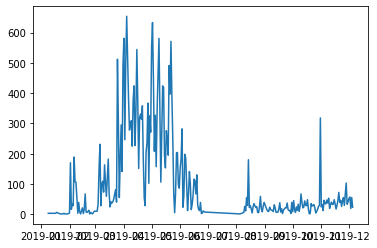

In [427]:
counts = encounters.groupby('date').count()['created_at']
plt.plot(counts)

In [428]:
def recalcdefaultpositions(encounters):
    bestpositions = np.arange(0,100)
    #bestpositions[0] = 8
    #bestpositions[1] = 7
    #bestpositions[2] = 9
    #bestpositions[3] = 6
    #bestpositions[4] = 10
    #bestpositions[5] = 5
    #bestpositions[6] = 11
    #bestpositions[7] = 4
    #bestpositions[8] = 12
    #bestpositions[9] = 3
    #bestpositions[10] = 13
    #bestpositions[11] = 2
    #bestpositions[12] = 14
    #bestpositions[13] = 1
    #bestpositions[14] = 15
    #bestpositions[15] = 0
    counts = encounters.groupby(['channel_id_x','channel_id_y','date']).count().sum(1).groupby(['channel_id_x','channel_id_y']).size().sort_values(ascending=False)
    defaultpositions = [None]*len(ids)
    nextpos = 0
    for (x,y),a in counts.iteritems():
        if defaultpositions[revids[x]] is None:
            defaultpositions[revids[x]] = bestpositions[nextpos]
            nextpos+=1
        if defaultpositions[revids[y]] is None:
            defaultpositions[revids[y]] = bestpositions[nextpos]
            nextpos+=1
    for i in range(len(defaultpositions)):
        if defaultpositions[i]==None:
            defaultpositions[i]=bestpositions[nextpos]
            nextpos+=1
    return defaultpositions

In [429]:
allpositions = []
defaultpositions = recalcdefaultpositions(encounters)
for i,d in enumerate(encounters['created_at'].dt.date.unique()):
    #if i%15==0:
    #    defaultpositions = recalcdefaultpositions(encounters[(encounters['created_at'].dt.date>d) & (encounters['created_at'].dt.date<d+timedelta(days=100))])
    positions = defaultpositions.copy()# np.arange(0.0,len(ids))
    encs = encounters[encounters['created_at'].dt.date==d]
    for x,y in zip(encs['channel_id_x'],encs['channel_id_y']):
        if x>y: x,y=y,x #x is smaller
        positions[revids[y]] = positions[revids[x]]+0.1
    allpositions.append(positions)

In [430]:
plotpositions = np.array(allpositions.copy())

In [436]:
mobileindexes = [revids[mcid] for mcid in mobilechannels]

In [443]:
plotpositions[:,mobileindexes]

array([[17. , 18. ,  9. , ..., 26. ,  1. , 32. ],
       [17. , 18. ,  9. , ..., 26. , 11.1, 32. ],
       [17. , 18. ,  9. , ..., 26. , 11.1, 32. ],
       ...,
       [17. , 18. ,  9. , ..., 26. ,  1. , 32. ],
       [17. , 18. ,  9. , ..., 26. ,  1. , 32. ],
       [17. , 18. ,  9. , ..., 26. ,  1. , 32. ]])

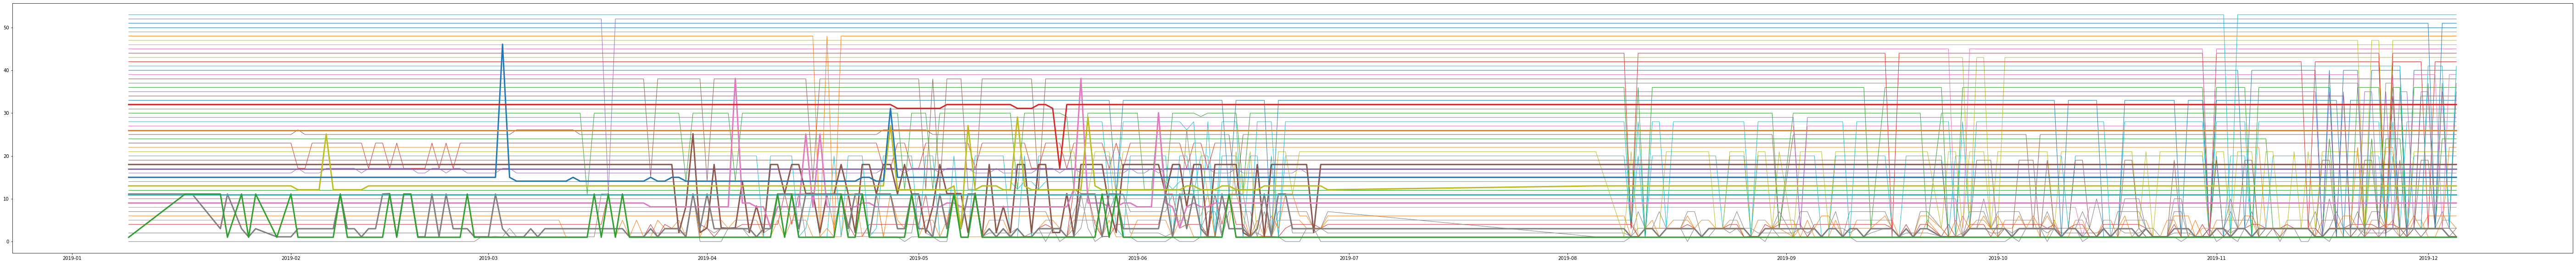

In [448]:
plt.figure(figsize=[100,10])
#plotpositions[plotpositions>15]=None
plt.plot(encounters['created_at'].dt.date.unique(),plotpositions,lw=1);
plt.plot(encounters['created_at'].dt.date.unique(),plotpositions[:,mobileindexes],lw=3);

#plt.xlim([0,25])
#plt.ylim([-1,15])

In [453]:
encounters.sort_values('created_at')

created_at  channel_id_x  entry_id_x  pm2_5_x  pm10_x  \
13654  2019-01-09 09:59:23        643676       14027     7.41   11.34   
13655  2019-01-09 10:00:31        643676       14028     7.15   10.48   
13657  2019-01-09 10:02:47        643676       14030     4.96    7.11   
17314  2019-01-17 09:38:29        643676       17718    12.06   19.65   
17611  2019-01-17 15:21:24        643676       18015     9.19   12.90   
...                    ...           ...         ...      ...     ...   
62032  2019-12-05 11:08:17        870146       62135    48.68   60.12   
62033  2019-12-05 11:09:40        870146       62136    46.43   58.08   
62632  2019-12-05 12:36:58        832254       65200    27.28   32.20   
62712  2019-12-05 14:28:22        832254       65280    51.40   65.02   
194667 2019-12-05 14:41:15        755614      194669    53.80   65.98   

        s2_pm2_5_x  s2_pm10_x  latitude_x  longitude_x  voltage_x  ...  \
13654        48.49       1.39    0.359963    32.585888       3.93  ...   
13655        28.66       1.39    0.359944    32.585869       3.93  ...   
13657        13.62       1.39    0.359951    32.585869       3.93  ...   
17314        41.03       1.39    0.319378    32.508427       3.83  ...   
17611        28.00       1.39    0.360950    32.583717       3.86  ...   
...            ...        ...         ...          ...        ...  ...   
62032        50.03      61.87    0.332278    32.569935       4.15  ...   
62033        50.35      62.63    0.332262    32.569904       4.15  ...   
62632        27.83      34.70    0.356433    32.573097       4.47  ...   
62712        50.70      63.97    0.356396    32.573044       4.47  ...   
194667       52.98      64.63    0.341144    32.601944       4.43  ...   

        longitude_y  voltage_y  altitude_y  wind_y  no_sats_y  hdope_y  \
13654     32.751827       3.69         NaN     NaN        NaN      NaN   
13655     32.751846       3.69         NaN     NaN        NaN      NaN   
13657     32.751831       3.70         NaN     NaN        NaN      NaN   
17314     32.554607       4.04         NaN     NaN        NaN      NaN   
17611     32.742321       3.05         NaN     NaN        NaN      NaN   
...             ...        ...         ...     ...        ...      ...   
62032     32.576164       4.23         NaN     NaN        NaN      NaN   
62033     32.576164       4.23         NaN     NaN        NaN      NaN   
62632     32.585773       4.07         NaN     NaN        NaN      NaN   
62712     32.586060       4.07         NaN     NaN        NaN      NaN   
194667    32.576427       4.07         NaN     NaN        NaN      NaN   

       temperature_y  humidity_y      created_at_2_y        date  
13654            NaN         NaN 2019-01-09 09:59:33  2019-01-09  
13655            NaN         NaN 2019-01-09 10:00:47  2019-01-09  
13657            NaN         NaN 2019-01-09 10:02:10  2019-01-09  
17314            NaN         NaN 2019-01-17 09:38:42  2019-01-17  
17611            NaN         NaN 2019-01-17 15:18:25  2019-01-17  
...              ...         ...                 ...         ...  
62032            NaN         NaN 2019-12-05 11:06:59  2019-12-05  
62033            NaN         NaN 2019-12-05 11:06:59  2019-12-05  
62632            NaN         NaN 2019-12-05 12:36:54  2019-12-05  
62712            NaN         NaN 2019-12-05 14:28:11  2019-12-05  
194667           NaN         NaN 2019-12-05 14:41:01  2019-12-05  

[29211 rows x 34 columns]

In [37]:
for i,r in encounters.sort_values('created_at').iterrows():
    r['created_at'],r['channel_id_x'],r['channel_id_y']


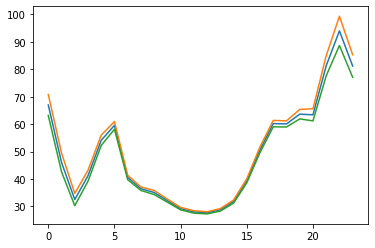

In [225]:
groupby = encounters.groupby(encounters['created_at'].dt.hour)
means = groupby.mean()['pm2_5_x']
variances = groupby.var()['pm2_5_x']
counts = groupby.count()['pm2_5_x']
plt.plot(means)
plt.plot(means+1.96*np.sqrt(variances/counts))
plt.plot(means-1.96*np.sqrt(variances/counts))

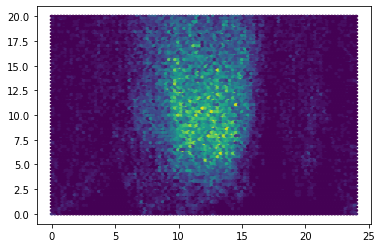

In [207]:

#plt.scatter(encounters['created_at'].dt.hour,encounters['pm2_5_x'],50,alpha=0.002)
plt.hexbin(encounters['created_at'].dt.hour+encounters['created_at'].dt.minute/60,encounters['pm2_5_x'],extent=[0,24,0,20])

In [321]:
xu

array([675801, 675805, 718028])

In [329]:
channelinfo.loc[cidx]['description']

'AIRQO UNIT with PMS5003 Tororo'

Text(0.5, 1.0, 'AIRQO UNIT with\nPMS5003 Tororo')

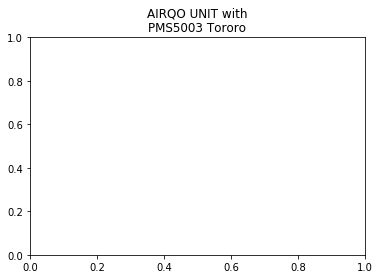

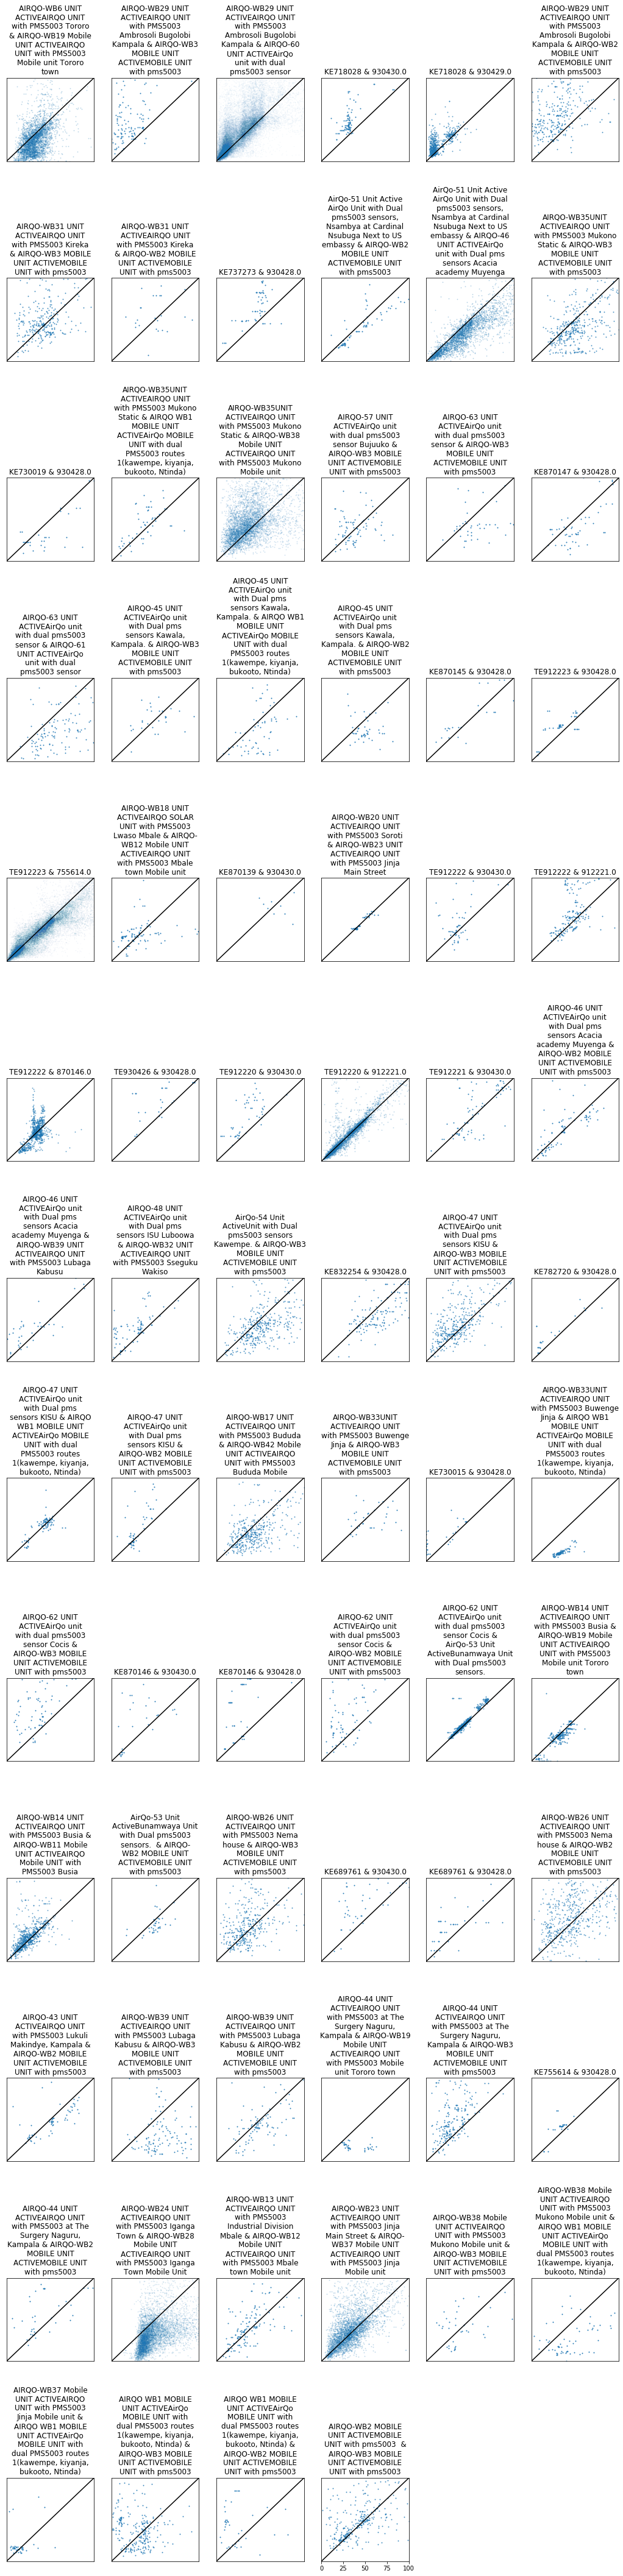

In [386]:
import textwrap
a=0
i=0
xu = encounters['channel_id_x'].unique()
yu = encounters['channel_id_y'].unique()
plt.figure(figsize=[6*3,25*3])
for cidx in xu:
    sx = encounters['channel_id_x']==cidx
    for cidy in yu: 
        sy = encounters['channel_id_y']==cidy
        #try:
        #    if cidx==xu[0]:
        #        desc = channelinfo.loc[cidy]['description']
        #        plt.title("\n".join(textwrap.wrap(desc,20)))
        #    if cidy==yu[0]:
        #        desc = channelinfo.loc[cidx]['description']
        #        plt.ylabel("\n".join(textwrap.wrap(desc,20)))
        #except KeyError:
        #    pass
        if (len(encounters[sx&sy])<30): continue
        #plt.subplot(len(yu),len(xu),i)
        i+=1
        
        plt.subplot(25,6,i)
        if i%6==0:i+=6
        alpha = 1/(0.97+len(encounters[sx&sy])/1000)
        plt.plot([0,100],[0,100],'k-')
        plt.scatter(encounters[sx&sy]['pm2_5_x'],encounters[sx&sy]['pm2_5_y'],1,alpha=alpha)
        plt.xlim([0,100])
        plt.ylim([0,100])
        if cidy!=yu[0]:
            plt.yticks([],[])
        if cidx!=xu[-1]:
            plt.xticks([],[])
        try:
            desc = channelinfo.loc[cidx]['name']+channelinfo.loc[cidx]['description']+"\n&\n"+channelinfo.loc[cidy]['name']+channelinfo.loc[cidy]['description']
            plt.title("\n".join(textwrap.wrap(desc,20)))
        except KeyError:
            plt.title("KE" + str(cidx)+" & "+str(cidy))
        except TypeError:
            plt.title("TE" + str(cidx)+" & "+str(cidy))
    

In [ ]:
## len(channelinfo['channel_id'])

In [384]:
channelinfo.loc[cidx]

name           AIRQO-WB2 MOBILE UNIT ACTIVE
description       MOBILE UNIT with pms5003 
channel_id                           667402
Name: 667402, dtype: object

In [284]:
len(encounters['channel_id_y'].unique())

38

In [283]:
len(encounters['channel_id_x'].unique())

60

In [278]:
cid1,cid2

(930431, 930431)

In [281]:
sum(encounters['channel_id_y']==cid2)

0

In [280]:
sum(encounters['channel_id_y'].astype(int)==cid2)

0

(0, 100)

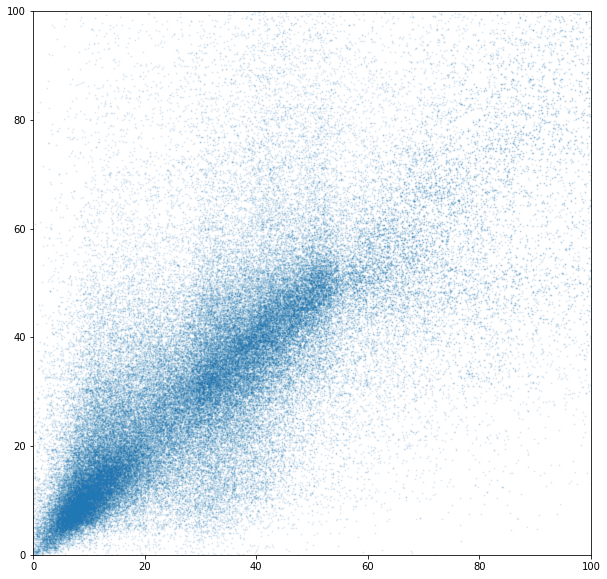

In [182]:
plt.figure(figsize=[10,10])
plt.scatter(encounters['pm2_5_x'],encounters['pm2_5_y'],1,alpha=0.1)
plt.xlim([0,100])
plt.ylim([0,100])

In [66]:
d1 = dfs[0].copy()
d2 = dfs[1].copy()

In [24]:
d1.sort_values("created_at", inplace=True)
d2.sort_values("created_at", inplace=True)

/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
d2.index = pd.IntervalIndex.from_arrays(d2['created_at']-pd.Timedelta(1,'minutes'),d2['created_at']+pd.Timedelta(1,'minutes'),closed='both')

In [41]:
np.sum(pd.isnull(d2.index))

0

In [55]:
len(d1)

369079

In [61]:
d2.loc[d1.iloc[[20000]].created_at]

KeyError: 

In [63]:
d1.created_at

0          2019-06-26 12:48:15
1          2019-06-12 02:17:58
2          2019-04-18 02:48:58
3          2019-08-06 13:25:26
4          2019-08-14 22:53:52
                   ...        
14326204   2019-06-13 14:59:41
14326205   2019-07-08 22:27:50
14326206   2019-08-27 10:00:58
14326207   2019-03-23 16:37:55
14326208   2019-04-05 17:42:45
Name: created_at, Length: 369079, dtype: datetime64[ns]

In [36]:
d1['B']=d2.loc[d1.A].B.values
d1['A']=d2.loc[d1.A].A.values

AttributeError: 'DataFrame' object has no attribute 'A'

In [68]:
d2['created_at_y']=d2['created_at']

In [70]:
len(d1)

369079

In [71]:
len(d2)

316088

In [77]:
pd.merge_asof(d1.sort_values("created_at"),d2.sort_values("created_at"),on='created_at',tolerance=pd.Timedelta(1,'minutes'),direction='nearest').columns

Index(['created_at', 'channel_id_x', 'entry_id_x', 'pm2_5_x', 'pm10_x',
       's2_pm2_5_x', 's2_pm10_x', 'latitude_x', 'longitude_x', 'voltage_x',
       'altitude_x', 'wind_x', 'no_sats_x', 'hdope_x', 'temperature_x',
       'humidity_x', 'channel_id_y', 'entry_id_y', 'pm2_5_y', 'pm10_y',
       's2_pm2_5_y', 's2_pm10_y', 'latitude_y', 'longitude_y', 'voltage_y',
       'altitude_y', 'wind_y', 'no_sats_y', 'hdope_y', 'temperature_y',
       'humidity_y', 'created_at_y'],
      dtype='object')

In [97]:
pd.merge_asof(d2.sort_values("created_at"),d1.sort_values("created_at"),on='created_at',tolerance=pd.Timedelta(timeprox,'minutes'),direction='nearest'). \
    dropna(subset=['latitude_x','longitude_x', 'latitude_y', 'longitude_y','pm2_5_x','pm2_5_y'])

created_at  channel_id_x  entry_id_x  pm2_5_x  pm10_x  \
0      2019-01-12 15:37:47        675805           1    28.30   29.53   
1      2019-01-12 15:39:02        675805           2    33.38   37.48   
1727   2019-01-20 06:16:35        675805        1728    49.33   60.10   
1728   2019-01-20 06:17:49        675805        1729    52.10   64.45   
1729   2019-01-20 06:19:05        675805        1730    61.23   70.38   
...                    ...           ...         ...      ...     ...   
316083 2020-02-03 22:01:47        675805      316084    16.93   18.20   
316084 2020-02-03 22:03:16        675805      316085    17.40   18.12   
316085 2020-02-03 22:04:36        675805      316086    16.28   16.83   
316086 2020-02-03 22:05:57        675805      316087    17.40   17.90   
316087 2020-02-03 22:07:17        675805      316088    16.80   17.10   

        s2_pm2_5_x  s2_pm10_x   latitude_x  longitude_x  voltage_x  ...  \
0            29.85      32.30     0.000000     0.000000       3.76  ...   
1            31.98      37.67  1000.000000  1000.000000        NaN  ...   
1727         55.07      66.47     0.674005    29.994017        NaN  ...   
1728         48.52      60.28     0.674004    29.993999        NaN  ...   
1729         59.17      69.53     0.673991    29.994036        NaN  ...   
...            ...        ...          ...          ...        ...  ...   
316083       18.43      18.57     0.674028    29.994061       4.46  ...   
316084       19.45      20.00     0.674034    29.994083       4.48  ...   
316085       16.62      17.35     0.674019    29.994068       4.46  ...   
316086       17.03      17.43     0.674010    29.994068       4.46  ...   
316087       17.33      17.72     0.674020    29.994047       4.48  ...   

        s2_pm10_y  latitude_y  longitude_y  voltage_y  altitude_y  wind_y  \
0           26.75    0.000000     0.000000       4.04         NaN     NaN   
1           26.75    0.000000     0.000000       4.04         NaN     NaN   
1727        93.58    0.674013    29.994017       3.97         NaN     NaN   
1728        93.58    0.674013    29.994017       3.97         NaN     NaN   
1729        93.58    0.674013    29.994017       3.97         NaN     NaN   
...           ...         ...          ...        ...         ...     ...   
316083      32.05    0.693675    34.181667       4.21      1207.5    0.25   
316084      38.05    0.693576    34.181705       4.20      1200.6    0.06   
316085      34.75    0.693748    34.181744       4.19      1222.9    0.06   
316086      34.30    0.693596    34.181683       4.20      1208.3    0.28   
316087      36.30    0.693678    34.181683       4.20      1217.3    0.34   

       no_sats_y  hdope_y  temperature_y  humidity_y  
0            NaN      NaN            NaN         NaN  
1            NaN      NaN            NaN         NaN  
1727         NaN      NaN            NaN         NaN  
1728         NaN      NaN            NaN         NaN  
1729         NaN      NaN            NaN         NaN  
...          ...      ...            ...         ...  
316083       7.0    112.0           22.0        95.0  
316084       6.0    202.0           22.0        95.0  
316085       6.0    132.0           22.0        95.0  
316086       7.0    120.0           22.0        95.0  
316087       6.0    129.0           22.0        95.0  

[263661 rows x 32 columns]

In [107]:
prox = 0.001
timeprox = 10
newdf = pd.merge_asof(d1.sort_values("created_at"),d2.sort_values("created_at"),on='created_at',tolerance=pd.Timedelta(timeprox,'minutes'),direction='nearest'). \
    dropna(subset=['latitude_x','longitude_x', 'latitude_y', 'longitude_y','pm2_5_x','pm2_5_y'])
newdf = newdf[(np.abs(newdf['latitude_x']-newdf['latitude_y'])<prox) & (np.abs(newdf['latitude_x']-newdf['latitude_y'])<prox)]
newdf[['created_at','created_at_y','latitude_x','longitude_x', 'latitude_y', 'longitude_y','pm2_5_x','pm2_5_y']]

created_at        created_at_y  latitude_x  longitude_x  \
120 2019-01-20 06:08:46 2019-01-20 06:16:35    0.673992    29.994028   
121 2019-01-20 06:10:00 2019-01-20 06:16:35    0.674016    29.994043   
122 2019-01-20 06:11:14 2019-01-20 06:16:35    0.673998    29.994057   
123 2019-01-20 06:12:28 2019-01-20 06:16:35    0.673998    29.994020   
124 2019-01-20 06:13:50 2019-01-20 06:16:35    0.674013    29.994017   

     latitude_y  longitude_y  pm2_5_x  pm2_5_y  
120    0.674005    29.994017    99.18    49.33  
121    0.674005    29.994017    77.58    49.33  
122    0.674005    29.994017    64.83    49.33  
123    0.674005    29.994017    89.22    49.33  
124    0.674005    29.994017    77.13    49.33

In [14]:
d1

created_at  channel_id  entry_id  pm2_5   pm10  s2_pm2_5  \
0        2019-06-26 12:48:15      675801    123558  39.30  54.35     33.55   
1        2019-06-12 02:17:58      675801    109446  73.67  80.12     63.53   
2        2019-04-18 02:48:58      675801     61117  28.80  33.37     22.53   
3        2019-08-06 13:25:26      675801    161088  22.08  30.30     23.92   
4        2019-08-14 22:53:52      675801    168867  30.53  32.82     30.67   
...                      ...         ...       ...    ...    ...       ...   
14326204 2019-06-13 14:59:41      675801    110962  46.48  60.78     38.82   
14326205 2019-07-08 22:27:50      675801    135433  31.28  36.10     22.80   
14326206 2019-08-27 10:00:58      675801    180665  18.15  28.23     26.45   
14326207 2019-03-23 16:37:55      675801     41388  55.22  67.10     51.40   
14326208 2019-04-05 17:42:45      675801     50299  25.83  27.75     21.12   

          s2_pm10  latitude  longitude  voltage  altitude  wind  no_sats  \
0           39.88  0.693691  34.181740     4.11    1223.6  0.21     10.0   
1           71.83  0.693688  34.181744     4.11    1214.3  0.05     10.0   
2           23.92  0.693689  34.181656     4.11    1220.4  0.08     10.0   
3           24.87  0.693731  34.181789     4.08    1201.5  0.05     10.0   
4           33.82  0.693712  34.181786     4.09    1242.1  0.09     10.0   
...           ...       ...        ...      ...       ...   ...      ...   
14326204    46.00  0.693590  34.181686     4.10    1202.7  0.03     10.0   
14326205    23.10  0.693679  34.181683     4.10    1192.9  0.07     10.0   
14326206    30.45  0.693692  34.181812     4.08    1229.2  0.07     10.0   
14326207    63.37  0.693667  34.181587     4.09    1219.3  0.03     10.0   
14326208    21.73  0.693694  34.181686     4.09    1211.0  0.44     10.0   

          hdope  temperature  humidity  
0          87.0         26.0      91.0  
1          76.0         24.0      95.0  
2          92.0         25.0      78.0  
3          91.0         31.0      51.0  
4          78.0         22.0      95.0  
...         ...          ...       ...  
14326204   91.0         30.0      62.0  
14326205  125.0         26.0      73.0  
14326206   93.0         32.0      52.0  
14326207   86.0         34.0      38.0  
14326208   80.0         31.0      52.0  

[369079 rows x 16 columns]

In [6]:
#circ of earth = 40,075 -> 40,075/360 =about 111,000m/degree
#so 110m == 0.001 degrees
d1lat = d1['latitude'].round(4)
d2lat = d2['latitude'].round(4)
d1long = d1['longitude'].round(4)
d2long = d2['longitude'].round(4)


In [11]:
import pandas as pd
import numpy as np
d2latunique = d2lat.unique()
d1latunique = d1lat.unique()
d2longunique = d2long.unique()
d1longunique = d1long.unique()

x1lat,x2lat = np.where((np.abs(d1latunique[:,None]-d2latunique)<0.002))
x1long,x2long = np.where((np.abs(d1longunique[:,None]-d2longunique)<0.002))
for d1optlat,d2optlat in zip(d1latunique[x1lat],d2latunique[x2lat]):
    break

In [13]:
d1latunique

array([6.9370e-01, 6.9360e-01, 6.9350e-01, 6.9380e-01, 6.9340e-01,
       1.0000e+03, 6.9330e-01, 6.9320e-01, 6.9400e-01, 6.9390e-01,
       6.8980e-01, 6.9310e-01, 0.0000e+00, 6.9300e-01, 6.9410e-01,
       6.7400e-01, 1.0742e+00, 1.0737e+00, 4.3050e-01, 2.9360e-01,
       2.7800e-01, 6.5190e-01, 6.9420e-01, 6.9440e-01, 3.1990e-01,
       6.5200e-01, 2.6140e-01, 6.2950e-01, 6.5290e-01, 6.1330e-01,
       6.5210e-01, 2.9860e-01, 6.3310e-01, 3.6940e-01, 2.4450e-01,
       2.8520e-01, 6.9270e-01, 6.5000e-01, 3.9340e-01, 1.0743e+00,
       4.5380e-01, 6.9280e-01, 6.9290e-01, 2.8840e-01, 1.7060e-01,
       1.9690e-01, 6.5310e-01, 6.9250e-01, 3.9130e-01, 1.9210e-01,
       1.7280e-01, 4.7720e-01, 2.3240e-01, 1.7330e-01, 4.9170e-01,
       1.7570e-01, 2.6040e-01, 4.6220e-01, 1.7400e-01, 4.2670e-01,
       1.9910e-01, 2.6020e-01, 1.8500e-01, 6.9450e-01, 6.9220e-01,
       6.5300e-01, 4.8700e-01, 6.3920e-01, 6.9750e-01, 3.9940e-01,
       6.2480e-01, 6.5180e-01, 6.9240e-01, 6.9430e-01, 1.8980e

# From Embassy - example for paper

In [74]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
import gpflow
import numpy as np
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary
import networkx as nx
%matplotlib inline

client = bigquery.Client.from_service_account_json("/home/mike/.gcp_keys/AirQo-519978d8cadc.json")
channelinfo = client.query('SELECT name,description,channel_id FROM `airqo-250220.thingspeak.channel`').to_dataframe()

import pickle
encounters = pickle.load(open('encounters.p','rb'))
df = pickle.load(open('alldata.p','rb'))

mobile = {}
for cid in df.channel_id.unique():
    diffs = df[df.channel_id==cid].latitude.diff()
    mobile[cid] = np.log(np.nanmedian(np.abs(diffs)))>-8

newmobile = {}
for m in mobile:
    for i in range(53):
        newmobile[str(m)+"_"+str(i)]=mobile[m]

prox_in_m = 150
prox = prox_in_m * 360.0/40075000
timeprox = 5 #5 minutes
embasssy_location = {'latitude':0.300225,'longitude':32.591553}

/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


In [67]:
def drawnet(network,G,mobile):
    mobs = np.array([float(mobile[n]) for n in G.nodes])
    pos = nx.kamada_kawai_layout(G)#,weight='num') #circular_layout(G)
    
    #pos = nx.spiral_layout(G)
    #pos = nx.spring_layout(G,pos=pos,k=0.01)
    #pos = nx.spring_layout(G,pos=pos,k=10)
    
    # Plot it
    #plt.figure(figsize=[3,3])
    #,

    options={"edge_color":np.log(network['num']),"node_color":mobs,"vmin":-2,"vmax":1,"width":5,"edge_cmap": plt.cm.Blues}
    nx.draw(G, pos, **options,with_labels=True)
    #plt.show()
    #return G

In [20]:
encounters['channel_id_y'] = encounters['channel_id_y'].astype(int)
subsetencounters = encounters[(encounters.created_at>=pd.Timestamp("2020-01-01")) & (encounters.created_at<pd.Timestamp("2020-04-01"))]

In [21]:
subsetencounters['channel_id_x'].unique()

array([718028, 718030, 737273, 832251, 730019, 870140, 870142, 870147,
       782718, 930427, 870145, 912223, 870139, 870143, 912222, 930426,
       912220, 870144, 912225, 912221, 782719, 782721, 832254, 782720,
       730016, 737278, 730015, 870146, 689761, 755612, 737276, 755614,
       689753, 930430, 930428])

In [22]:
timesubsetencounters = subsetencounters.copy()
timesubsetencounters['channel_id_x']=subsetencounters['channel_id_x'].astype(str)+"_"+subsetencounters['created_at'].dt.month.astype('str')
timesubsetencounters['channel_id_y']=subsetencounters['channel_id_y'].astype(str)+"_"+subsetencounters['created_at'].dt.month.astype('str')

In [23]:
summaryencounters = timesubsetencounters.groupby(by=['channel_id_x','channel_id_y'])['created_at'].count()
summaryencounters = summaryencounters.reset_index() # .index,summaryencounters])
summaryencounters.columns = ['from','to','num']
summaryencounters = summaryencounters[summaryencounters.num>10]

In [148]:
for idx in set(np.r_[timesubsetencounters.channel_id_x.unique(),timesubsetencounters.channel_id_y.unique()]):
    label,week = idx.split("_")
    #print(label,week)
    #print()
    summaryencounters=summaryencounters.append({'from':label+'_'+str(week),'to':label+'_'+str(int(week)+1),'num':10000},ignore_index=True)

In [149]:
timemobile = {}
for m in mobile:
    for i in range(53):
        timemobile[str(m)+"_"+str(i)]=mobile[m]

In [150]:
summaryencounters['lognum']=np.log(summaryencounters['num'])
G=nx.from_pandas_edgelist(summaryencounters,'from','to',edge_attr='lognum')

In [151]:
done = False
while not done:
    done = True
    for n in G.nodes:
        if len(list(G.neighbors(n)))<2:
            G.remove_node(n)
            done = False
            break
            

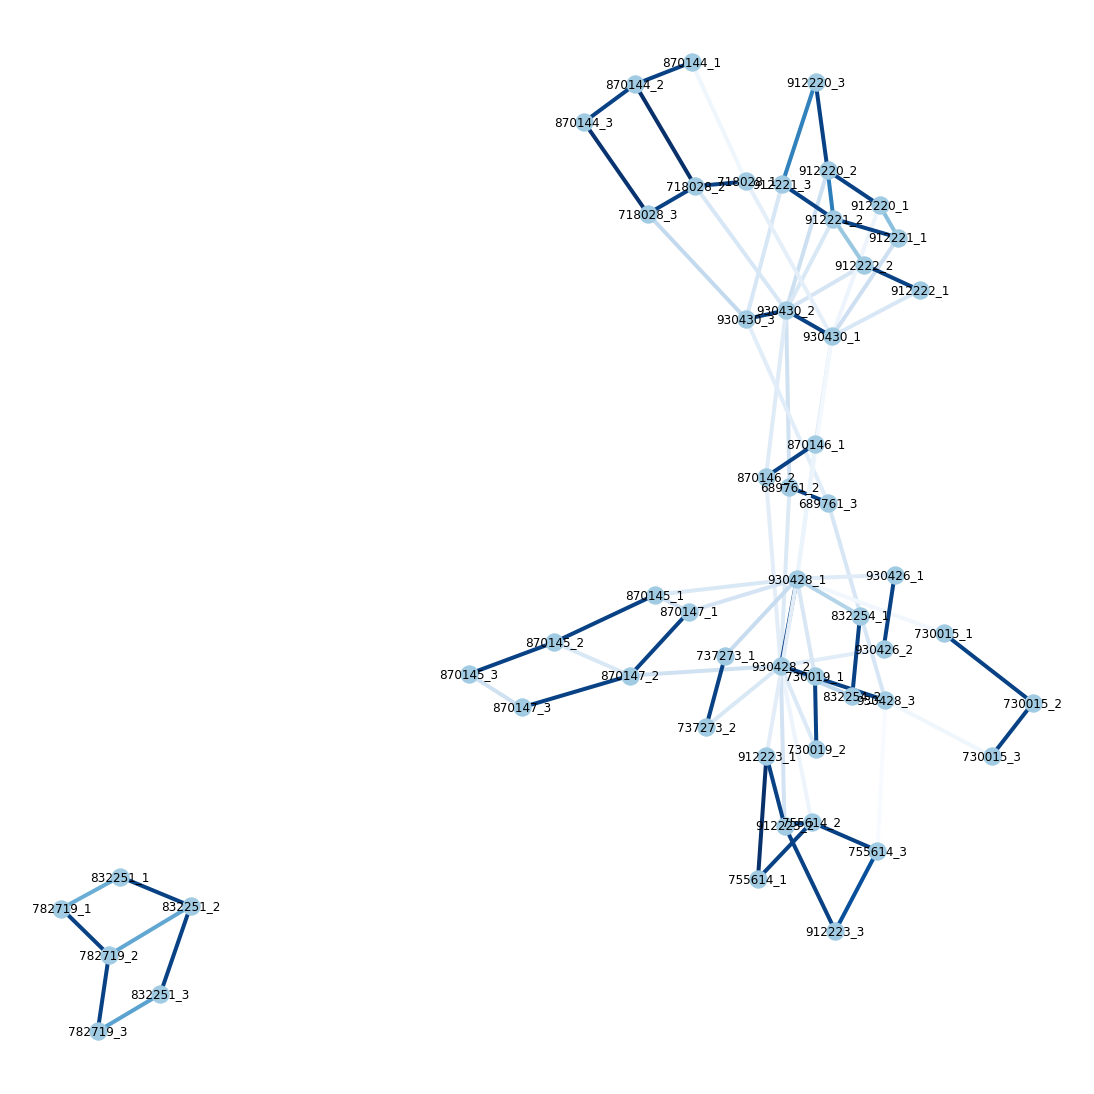

In [155]:
plt.figure(figsize=[15,15])
#G=nx.star_graph(20)
pos=nx.spring_layout(G)
colors = [G.get_edge_data(e[0],e[1])['lognum'] for e in G.edges]
nx.draw(G,pos,node_color='#A0CBE2',edge_color=colors,width=4,vmin=0,vmax=5,edge_cmap=plt.cm.Blues,with_labels=True)

In [197]:
startnode = '782719_3' #list(G.nodes())[0]

In [279]:
def getcycle(H,cycle,currentnode):
    print(".",end="")
    #print("currentnode:" + currentnode+"  cycle:"+str(cycle))
    startnode=cycle[0]
    neighbours = list(H.neighbors(currentnode))
    
    J = H.copy()
    
    if currentnode==startnode:
        if len(cycle)>1:
            #print("returning")
            #print(cycle)
            return [cycle]
    else:
        cycle.append(currentnode)
        J.remove_node(currentnode)
    #print(neighbours)    
    if len(neighbours)==0: return []
    
    
    
    #print(cycle)
    cycles = []
    for ne in neighbours:
        cyc = getcycle(J,cycle.copy(),ne)
        if len(cyc)>0:
            cycles.extend(cyc)
    return cycles
    print("=====")

def getallcycles(G,startnode):
    cycle = [startnode]
    cycles = []
    for ne in G.neighbors(startnode):
        H = G.copy()
        H.remove_edge(startnode,ne)
        cycles.extend(getcycle(H,cycle.copy(),ne))
    for c in cycles:
        c.append(startnode)
    uniquecycles = []
    for i,c in enumerate(cycles):
        unique = True
        for d in cycles[i:]:
            if d[-1::-1]==c:
                unique = False
        if unique: uniquecycles.append(c)
    return uniquecycles

In [280]:
H = G.copy()
allcycles = []
#while len(H)>0:
for it in range(10):
    cycles = getallcycles(H,list(H.nodes)[0])
    allcycles.extend(cycles)
    a = []
    [a.extend(c) for c in cycles]
    for n in set(a):
        H.remove_node(n)
    print(len(H))
#[str(cyc[-1::-1]) for cyc in cycles]
#print(cycles)
cycles[0]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

KeyboardInterrupt: 

{'782719_1', '782719_2', '782719_3', '832251_1', '832251_2', '832251_3'}

In [247]:
[str(cyc) for cyc in cycles]

["['782719_3', '832251_3', '832251_2', '832251_1', '782719_1', '782719_2', '782719_3']",
 "['782719_3', '832251_3', '832251_2', '782719_2', '782719_3']",
 "['782719_3', '782719_2', '782719_1', '832251_1', '832251_2', '832251_3', '782719_3']",
 "['782719_3', '782719_2', '832251_2', '832251_3', '782719_3']"]

In [175]:
for cyc in nx.simple_cycles(G.to_directed()):
    print(cyc)


['782719_3', '782719_2']
['782719_3', '782719_2', '782719_1', '832251_1', '832251_2', '832251_3']
['782719_3', '782719_2', '832251_2', '832251_3']
['782719_3', '832251_3', '832251_2', '832251_1', '782719_1', '782719_2']
['782719_3', '832251_3', '832251_2', '782719_2']
['782719_3', '832251_3']
['782719_1', '782719_2']
['782719_1', '782719_2', '832251_2', '832251_1']
['782719_1', '832251_1', '832251_2', '782719_2']
['782719_1', '832251_1']
['832251_3', '832251_2']
['782719_2', '832251_2']
['832251_2', '832251_1']
['930426_1', '930426_2']
['930426_1', '930426_2', '930428_2', '930428_3', '755614_3', '755614_2', '755614_1', '912223_1', '930428_1']
['930426_1', '930426_2', '930428_2', '930428_3', '755614_3', '755614_2', '912223_2', '912223_1', '930428_1']
['930426_1', '930426_2', '930428_2', '930428_3', '755614_3', '912223_3', '912223_2', '912223_1', '930428_1']
['930426_1', '930426_2', '930428_2', '930428_3', '755614_3', '912223_3', '912223_2', '755614_2', '755614_1', '912223_1', '930428_1'

['930426_1', '930426_2', '930428_2', '930428_3', '689761_3', '930430_3', '912221_3', '912220_3', '912220_2', '912220_1', '930430_1', '912222_1', '912222_2', '930430_2', '870146_2', '870146_1', '930428_1']
['930426_1', '930426_2', '930428_2', '930428_3', '689761_3', '930430_3', '912221_3', '912220_3', '912220_2', '912220_1', '930430_1', '912222_1', '912222_2', '912221_2', '930430_2', '870146_2', '870146_1', '930428_1']
['930426_1', '930426_2', '930428_2', '930428_3', '689761_3', '930430_3', '912221_3', '912220_3', '912220_2', '912220_1', '930430_1', '912221_1', '912221_2', '912222_2', '930430_2', '870146_2', '870146_1', '930428_1']
['930426_1', '930426_2', '930428_2', '930428_3', '689761_3', '930430_3', '912221_3', '912220_3', '912220_2', '912220_1', '930430_1', '912221_1', '912221_2', '930430_2', '870146_2', '870146_1', '930428_1']
['930426_1', '930426_2', '930428_2', '930428_3', '689761_3', '930430_3', '912221_3', '912220_3', '912220_2', '912220_1', '930430_1', '870146_1', '930428_1']

['930426_1', '930426_2', '930428_2', '912223_2', '912223_1', '755614_1', '755614_2', '755614_3', '930428_3', '689761_3', '930430_3', '718028_3', '870144_3', '870144_2', '870144_1', '718028_1', '718028_2', '930430_2', '912220_2', '912220_3', '912221_3', '912221_2', '912221_1', '912220_1', '930430_1', '870146_1', '930428_1']
['930426_1', '930426_2', '930428_2', '912223_2', '912223_1', '755614_1', '755614_2', '755614_3', '930428_3', '689761_3', '930430_3', '718028_3', '870144_3', '870144_2', '870144_1', '718028_1', '718028_2', '930430_2', '912220_2', '912220_3', '912221_3', '912221_2', '912222_2', '912222_1', '930430_1', '930428_1']
['930426_1', '930426_2', '930428_2', '912223_2', '912223_1', '755614_1', '755614_2', '755614_3', '930428_3', '689761_3', '930430_3', '718028_3', '870144_3', '870144_2', '870144_1', '718028_1', '718028_2', '930430_2', '912220_2', '912220_3', '912221_3', '912221_2', '912222_2', '912222_1', '930430_1', '870146_1', '930428_1']
['930426_1', '930426_2', '930428_2', 

['930426_1', '930426_2', '930428_2', '912223_2', '912223_3', '755614_3', '930428_3', '689761_3', '930430_3', '912221_3', '912221_2', '912220_2', '912220_1', '912221_1', '930430_1', '930428_1']
['930426_1', '930426_2', '930428_2', '912223_2', '912223_3', '755614_3', '930428_3', '689761_3', '930430_3', '912221_3', '912221_2', '912220_2', '912220_1', '912221_1', '930430_1', '912222_1', '912222_2', '930430_2', '870146_2', '870146_1', '930428_1']
['930426_1', '930426_2', '930428_2', '912223_2', '912223_3', '755614_3', '930428_3', '689761_3', '930430_3', '912221_3', '912221_2', '912220_2', '912220_1', '912221_1', '930430_1', '870146_1', '930428_1']
['930426_1', '930426_2', '930428_2', '912223_2', '912223_3', '755614_3', '930428_3', '689761_3', '930430_3', '912221_3', '912221_2', '912220_2', '912220_1', '912221_1', '930430_1', '718028_1', '718028_2', '930430_2', '870146_2', '870146_1', '930428_1']
['930426_1', '930426_2', '930428_2', '912223_2', '912223_3', '755614_3', '930428_3', '689761_3',

['930426_1', '930426_2', '930428_2', '912223_2', '755614_2', '755614_3', '930428_3', '689761_3', '689761_2', '930430_2', '912222_2', '912221_2', '912221_1', '930430_1', '930428_1']
['930426_1', '930426_2', '930428_2', '912223_2', '755614_2', '755614_3', '930428_3', '689761_3', '689761_2', '930430_2', '912222_2', '912221_2', '912221_1', '930430_1', '870146_1', '930428_1']
['930426_1', '930426_2', '930428_2', '912223_2', '755614_2', '755614_3', '930428_3', '689761_3', '689761_2', '930430_2', '912222_2', '912221_2', '912221_1', '912220_1', '912220_2', '912220_3', '912221_3', '930430_3', '718028_3', '718028_2', '718028_1', '930430_1', '930428_1']
['930426_1', '930426_2', '930428_2', '912223_2', '755614_2', '755614_3', '930428_3', '689761_3', '689761_2', '930430_2', '912222_2', '912221_2', '912221_1', '912220_1', '912220_2', '912220_3', '912221_3', '930430_3', '718028_3', '718028_2', '718028_1', '930430_1', '870146_1', '930428_1']
['930426_1', '930426_2', '930428_2', '912223_2', '755614_2',

['930426_1', '930426_2', '930428_2', '912223_2', '755614_2', '755614_3', '930428_3', '689761_3', '930430_3', '718028_3', '718028_2', '718028_1', '930430_1', '912220_1', '912220_2', '912221_2', '930430_2', '870146_2', '870146_1', '930428_1']
['930426_1', '930426_2', '930428_2', '912223_2', '755614_2', '755614_3', '930428_3', '689761_3', '930430_3', '718028_3', '718028_2', '718028_1', '930430_1', '912220_1', '912221_1', '912221_2', '912221_3', '912220_3', '912220_2', '930430_2', '870146_2', '870146_1', '930428_1']
['930426_1', '930426_2', '930428_2', '912223_2', '755614_2', '755614_3', '930428_3', '689761_3', '930430_3', '718028_3', '718028_2', '718028_1', '930430_1', '912220_1', '912221_1', '912221_2', '912222_2', '930430_2', '870146_2', '870146_1', '930428_1']
['930426_1', '930426_2', '930428_2', '912223_2', '755614_2', '755614_3', '930428_3', '689761_3', '930430_3', '718028_3', '718028_2', '718028_1', '930430_1', '912220_1', '912221_1', '912221_2', '930430_2', '870146_2', '870146_1', 

['930426_1', '930426_2', '930428_2', '870146_2', '870146_1', '930430_1', '912221_1', '912221_2', '912222_2', '930430_2', '689761_2', '689761_3', '930428_3', '755614_3', '755614_2', '755614_1', '912223_1', '930428_1']
['930426_1', '930426_2', '930428_2', '870146_2', '870146_1', '930430_1', '912221_1', '912221_2', '912222_2', '930430_2', '689761_2', '689761_3', '930428_3', '755614_3', '755614_2', '912223_2', '912223_1', '930428_1']
['930426_1', '930426_2', '930428_2', '870146_2', '870146_1', '930430_1', '912221_1', '912221_2', '912222_2', '930430_2', '689761_2', '689761_3', '930428_3', '755614_3', '912223_3', '912223_2', '912223_1', '930428_1']
['930426_1', '930426_2', '930428_2', '870146_2', '870146_1', '930430_1', '912221_1', '912221_2', '912222_2', '930430_2', '689761_2', '689761_3', '930428_3', '755614_3', '912223_3', '912223_2', '755614_2', '755614_1', '912223_1', '930428_1']
['930426_1', '930426_2', '930428_2', '870146_2', '870146_1', '930430_1', '912221_1', '912221_2', '912222_2',

KeyboardInterrupt: 

In [170]:
nx.find_cycle(G)

[('689761_2', '930428_2'),
 ('930428_2', '730019_2'),
 ('730019_2', '730019_1'),
 ('730019_1', '930428_1'),
 ('930428_1', '730015_1'),
 ('730015_1', '730015_2'),
 ('730015_2', '730015_3'),
 ('730015_3', '930428_3'),
 ('930428_3', '689761_3'),
 ('689761_3', '930430_3'),
 ('930430_3', '718028_3'),
 ('718028_3', '870144_3'),
 ('870144_3', '870144_2'),
 ('870144_2', '718028_2'),
 ('718028_2', '930430_2'),
 ('930430_2', '689761_2')]

ValueError: Invalid RGBA argument: 1

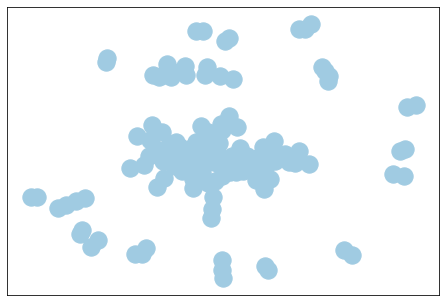

In [108]:


colors=range(1,len(G)+1)
pos=nx.spring_layout(G)
nx.draw(G,pos,node_color='#A0CBE2',edge_color=colors,width=4,edge_cmap=plt.cm.Blues,with_labels=False)


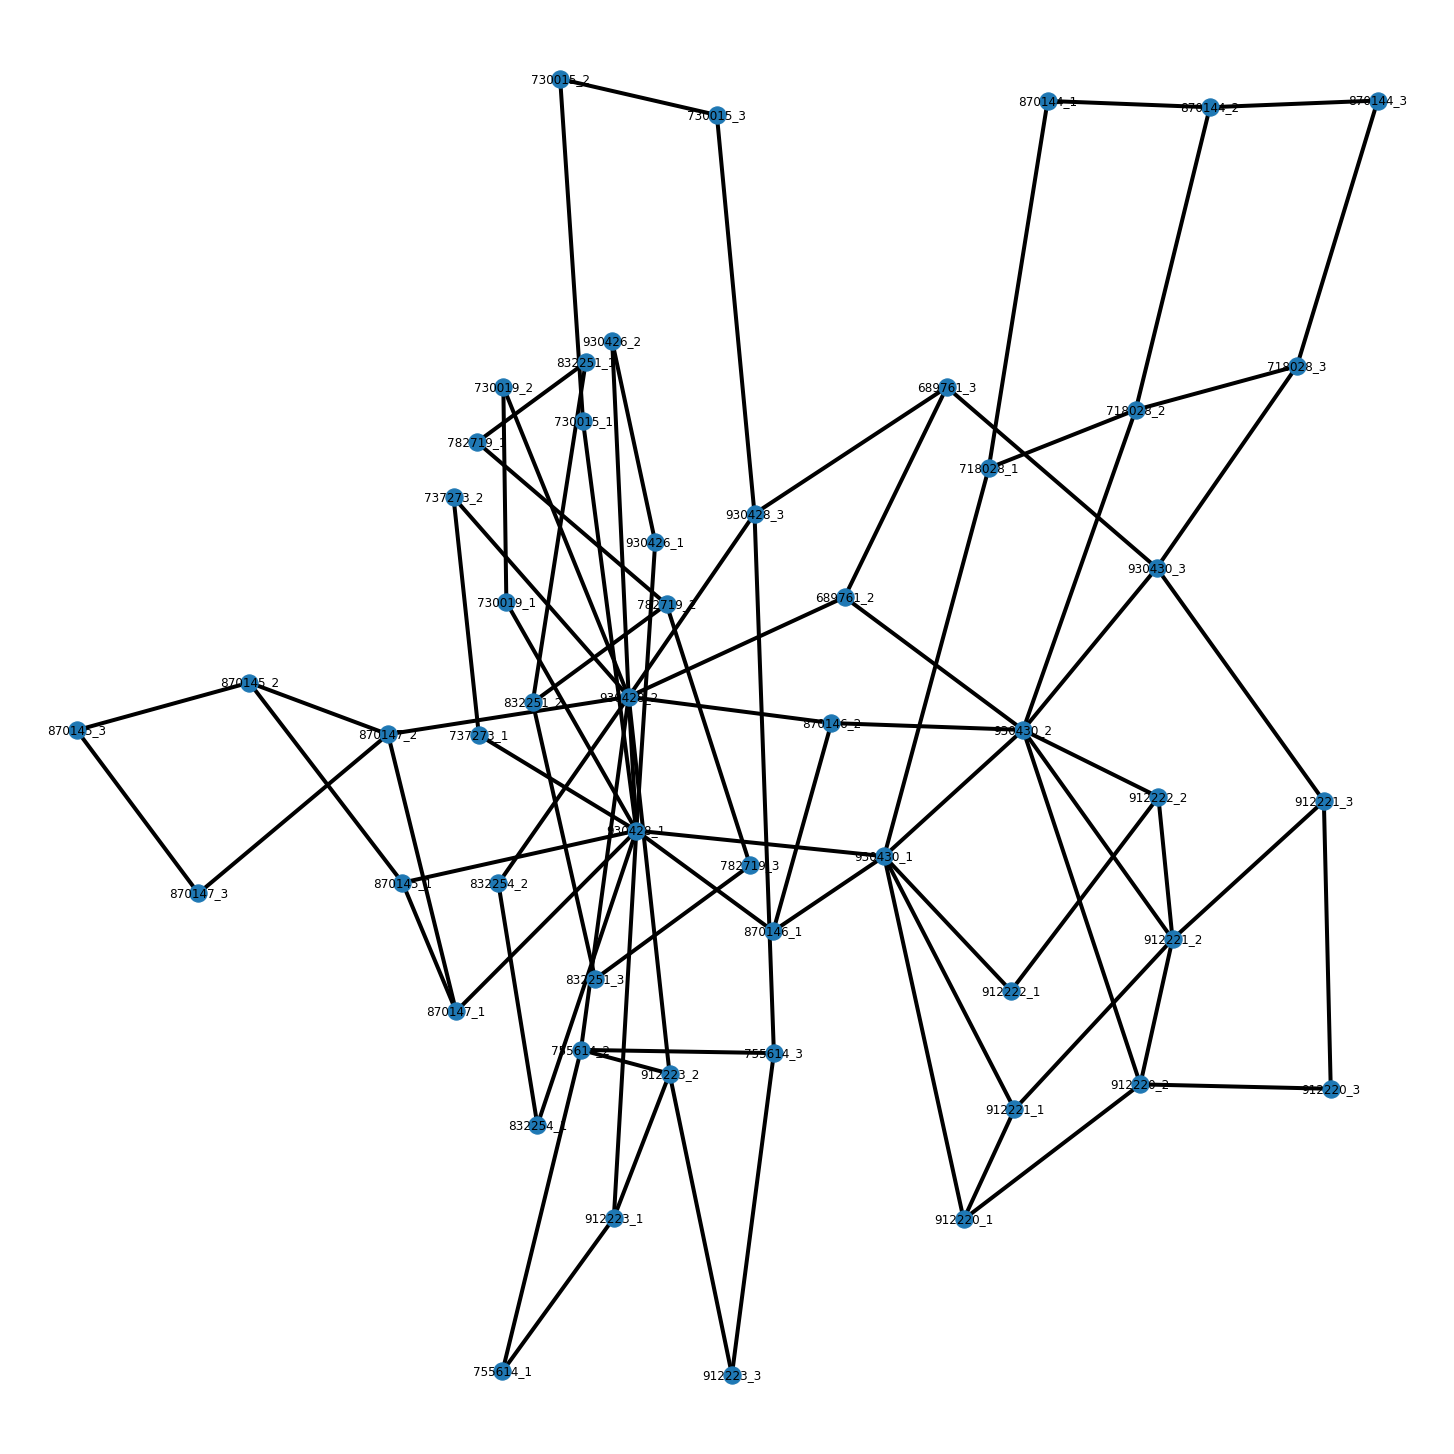

In [99]:
plt.figure(figsize=[20,20])
#drawnet(summaryencounters,G,timemobile)
mobs = np.array([float(newmobile[n]) for n in G.nodes])
pos = nx.kamada_kawai_layout(G)#,weight='num') #circular_layout(G)
#options={"edge_color":"lognum","node_color":mobs,"vmin":-2,"vmax":1,"width":5,"edge_cmap": plt.cm.Blues}
#nx.draw(G, pos, **options,with_labels=True)
colors = range(len([G.get_edge_data(e[0],e[1])['lognum'] for e in G.edges]))

nx.draw(G, pos, edge_colors=colors, width=4,edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()

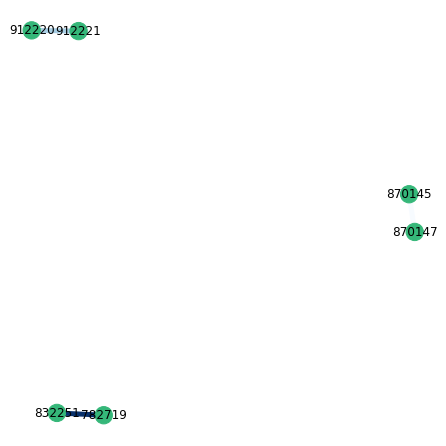

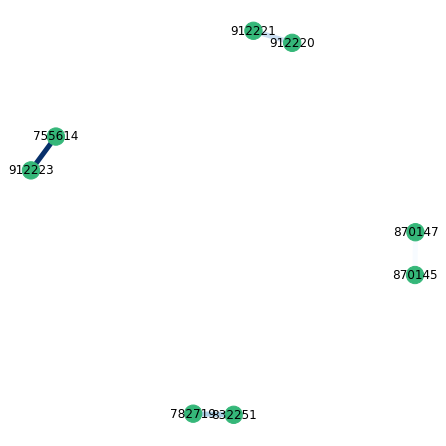

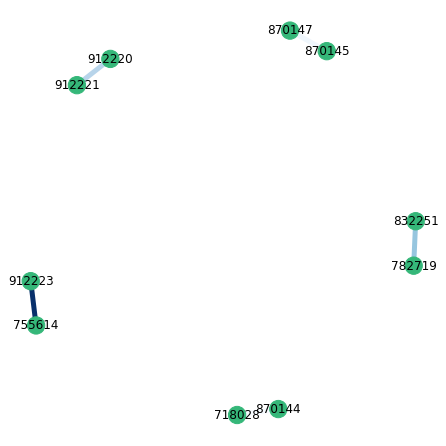

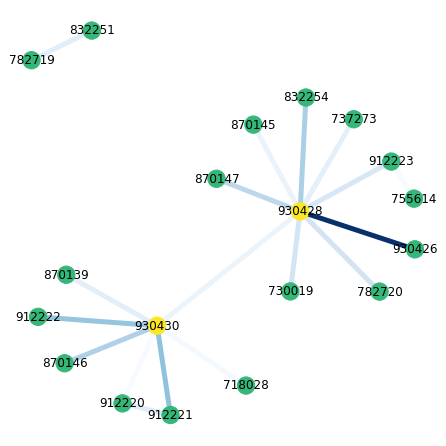

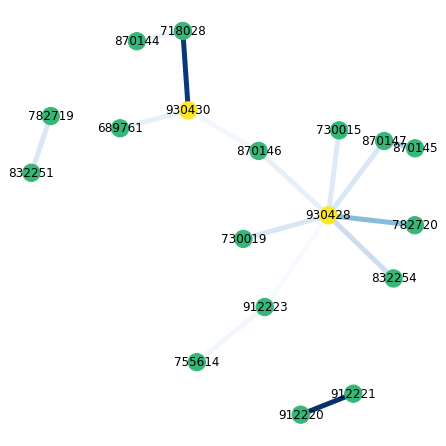

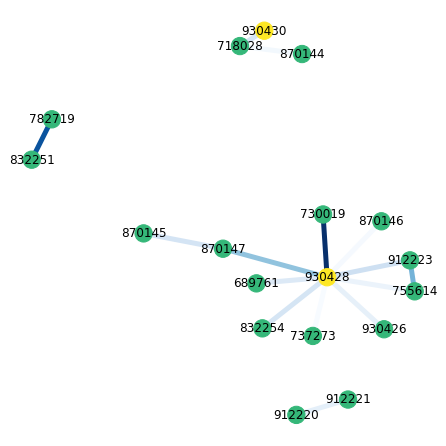

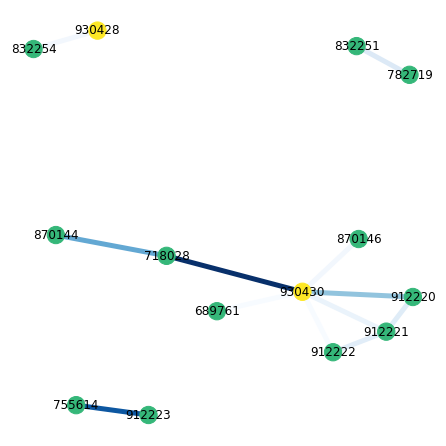

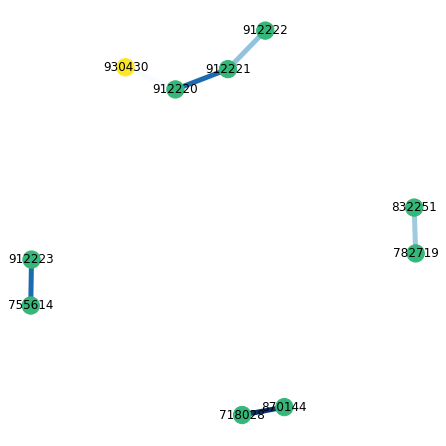

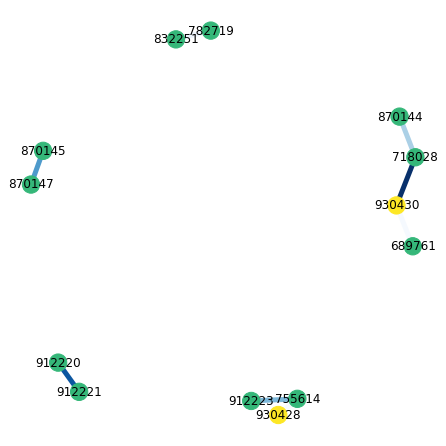

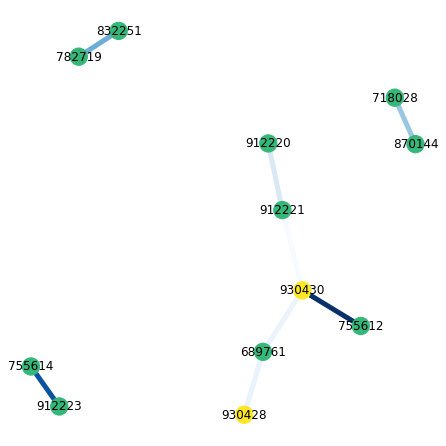

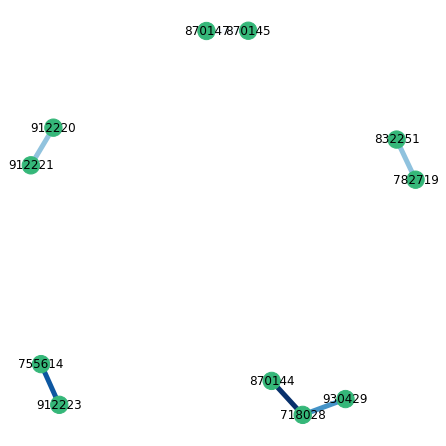

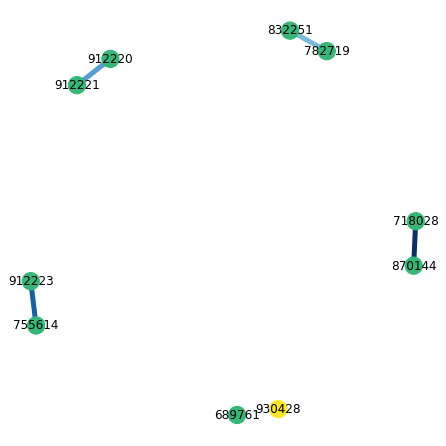

In [524]:
#plt.figure(figsize=[30,45])
st = pd.Timestamp("2020-01-01")
ts = pd.Timedelta(7,"days")
for i in range(12):
    #plt.subplot(4,3,i+1)
    plt.figure(figsize=[6,6])
    encounters['channel_id_y'] = encounters['channel_id_y'].astype(int)
    subsetencounters = encounters[(encounters.created_at>=st) & (encounters.created_at<st+ts)]
    summaryencounters = subsetencounters.groupby(by=['channel_id_x','channel_id_y'])['created_at'].count()
    summaryencounters = summaryencounters.reset_index() # .index,summaryencounters])
    summaryencounters.columns = ['from','to','num']
    summaryencounters = summaryencounters[summaryencounters.num>10]
    #subsetencounters['channel_id_x']=subsetencounters['channel_id_x'].astype(str)+"_"+subsetencounters['created_at'].dt.week.astype('str')
    drawnet(summaryencounters,mobile)
    plt.grid()
    st=st+ts

/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [541]:
subsetencounters['channel_id_x'].unique()

array(['718028_12', '718028_13', '832251_12', '832251_13', '870142_13',
       '870147_12', '870147_13', '912223_12', '912223_13', '870139_12',
       '870143_12', '912222_13', '912220_12', '912220_13', '782719_12',
       '689761_13', '755612_12'], dtype=object)

In [284]:
for i,(f,t,n) in summaryencounters.iterrows():
    encs = (((subsetencounters.channel_id_x==f) | (subsetencounters.channel_id_x==t)) & ((subsetencounters.channel_id_y==f) | (subsetencounters.channel_id_y==t)))
    #print(f,t,n)
    pmx = subsetencounters[encs]['pm2_5_x']
    pmy = subsetencounters[encs]['pm2_5_y']
    print(np.mean(pmx/pmy))
    #plt.figure(figsize=[5,5])
    #plt.scatter(pmx,pmy,5)
    #plt.axis('equal')
    #plt.grid()
    #plt.xlim([0,200])
    #plt.ylim([0,200])
    #plt.plot([0,200],[0,200],'k-')

0.5848229366114233
0.8444119949637926
0.5506251951284682
0.6793911152797597
1.5147585083323634
1.240047639880535
2.2442974487668494
1.4789028026503797
0.9651011388092283
0.5734165861171858
0.5964803396701283
0.8898821494303679
0.8324830815942156
1.1162370512901456
0.8362058621647744


In [297]:
#feb
#nodelist = [930430,912221,912220]
nodelist = [930430,912222,912221,912220]

#all daa
#nodelist = [870146,930428,689761,930430]
#nodelist = [912220,912221,930430]
totallogratio = 0.0
totallogratiovar = 0.0
nodelist.append(nodelist[0])
for f,t in zip(nodelist[:-1],nodelist[1:]):
    #print("----")
    pairenc = subsetencounters[((subsetencounters.channel_id_x==f) & (subsetencounters.channel_id_y==t))]
    pmf = pairenc['pm2_5_x']
    pmt = pairenc['pm2_5_y']
    if len(pmf)==0:
        pairenc = subsetencounters[((subsetencounters.channel_id_x==t) & (subsetencounters.channel_id_y==f))]
        pmt = pairenc['pm2_5_x']
        pmf = pairenc['pm2_5_y']
    print("%d->%d,len:%d"%(f,t,len(pmf)))
    logratios = np.log(pmf/pmt)
    logratio = np.mean(logratios)
    logratiovar = np.var(logratios)
    print(logratio)
    totallogratio += logratio
    totallogratiovar += logratiovar/len(logratios)
print("==============")
print(totallogratio)
print("+/-",np.sqrt(totallogratiovar)*1.96)

print(np.exp([totallogratio-np.sqrt(totallogratiovar)*1.96,totallogratio,totallogratio+np.sqrt(totallogratiovar)*1.96]))

930430->912222,len:38
0.3200989887448697
912222->912221,len:188
-0.19031599218280065
912221->912220,len:1882
0.07308365134616215
912220->930430,len:52
-0.6626132595977641
-0.4597466116895329
+/- 0.22720568177475226
[0.50310706 0.63144363 0.79251731]


array([0.50310706, 0.63144363, 0.79251731])

In [179]:
subsetencounters[subsetencounters['channel_id_x']==718028].iloc[0:1]


                created_at  channel_id_x  entry_id_x  pm2_5_x  pm10_x  \
267375 2020-01-08 17:23:13        718028      267377    67.95   73.82   

        s2_pm2_5_x  s2_pm10_x  latitude_x  longitude_x  voltage_x  ...  \
267375       72.52      78.13    0.307217    32.620495       4.03  ...   

        latitude_y  longitude_y  voltage_y  altitude_y  wind_y  no_sats_y  \
267375    0.306969    32.651646        3.6      1164.4    0.01       12.0   

       hdope_y  temperature_y  humidity_y      created_at_2_y  
267375    61.0            0.0     27749.0 2020-01-08 17:27:04  

[1 rows x 33 columns]


In [180]:
subsetencounters[subsetencounters['channel_id_y']==718028].iloc[0:1]

Empty DataFrame
Columns: [created_at, channel_id_x, entry_id_x, pm2_5_x, pm10_x, s2_pm2_5_x, s2_pm10_x, latitude_x, longitude_x, voltage_x, altitude_x, wind_x, no_sats_x, hdope_x, temperature_x, humidity_x, created_at_2_x, channel_id_y, entry_id_y, pm2_5_y, pm10_y, s2_pm2_5_y, s2_pm10_y, latitude_y, longitude_y, voltage_y, altitude_y, wind_y, no_sats_y, hdope_y, temperature_y, humidity_y, created_at_2_y]
Index: []

[0 rows x 33 columns]

In [170]:
pmx/pmy

90345    0.322008
90346    0.473101
90347    0.493815
90464    0.669704
91268    0.957451
           ...   
7669     1.158015
7670     1.069114
9284     5.165807
9536     2.115892
12095    4.857035
Length: 129, dtype: float64

In [167]:
pmy

90345     242.23
90346     171.38
90347     171.38
90464     170.12
91268      55.70
92234      54.95
92695     215.03
92696     277.63
92710     232.95
93197     155.42
93751     289.00
93994     136.97
94494     245.08
94661     123.20
94662     123.20
95239      90.03
96242      38.18
96693      76.50
98638      42.32
99470       8.40
99755     144.67
99756     144.67
99757     144.67
99758     144.67
99883     121.38
99891     175.88
99893     186.00
99929     102.65
99930     102.65
100554     82.17
100555     15.25
100556     10.47
100558     10.37
100559      7.83
100560      6.27
100561      8.67
100562     11.27
100564     41.83
100695     62.47
101820     70.68
102968    114.32
103376    142.77
104116    102.17
105727     79.02
105728     79.02
112868     61.67
112869     62.62
113017    261.80
113019     44.48
114315     71.57
115301    106.22
115385     52.15
115398     67.05
117673    191.08
117689    203.95
117697    196.37
122630     92.13
122984    153.13
123426     56.

In [157]:
def buildpath(path,encounters,):
    (summaryencounters['from']==870146) | (summaryencounters['to']==870146)
summaryencounters

from        to    num
1   689761  930428.0     65
2   689761  930430.0     73
3   718028  870144.0  39259
5   718028  930429.0    783
6   718028  930430.0    129
10  730015  930428.0     31
14  730019  930428.0     64
16  737273  930428.0    105
23  755614  930428.0     34
30  782720  930428.0     36
33  832251  782719.0   1869
36  832254  930428.0    186
45  870145  930428.0     45
47  870146  930428.0     50
48  870146  930430.0     59
49  870147  870145.0    142
50  870147  930428.0     88
52  912220  912221.0   4169
54  912220  930430.0     73
57  912221  930430.0    122
58  912222  912221.0    188
60  912222  930430.0     79
61  912223  755614.0  33127
62  912223  930428.0     77
66  930426  930428.0     52

1     False
2     False
3     False
5     False
6     False
10    False
14    False
16    False
23    False
30    False
33    False
36    False
45    False
47     True
48     True
49    False
50    False
52    False
54    False
57    False
58    False
60    False
61    False
62    False
66    False
dtype: bool